# PART 2
## Filter cells

Cells with low library size and low number of genes will be filtered out.

- **INPUT:**
    - ```$counts.RData``` 
    - ```anno_cells.RData```
    - ```anno_samples.RData```
    - ```anno_genes.RData```
    
- **NOTES:**

    The '_ctf' ending in the file names stands for cell type filter.
    
- **OUTPUT:**

    -  ```counts_cf.RData``` 
    -  ```anno_cells_cf.RData``` 
    -  ```anno_samples_cf.RData``` 
    -  ```anno_genes_cf.RData``` 

In [225]:
library(ggplot2)
library(Matrix)
library(dplyr)

In [226]:
path <- paste0(getwd(),"/pdata")
print("path is:")
print(path)

[1] "path is:"
[1] "/work/project/ladcol_013/algo_ulc/pdata"


In [227]:
options(repr.plot.width=15,repr.plot.height=8)

In [228]:
load(paste0(path,"/counts.RData"))
print(dim(counts))

[1]  21784 365492


In [229]:
print(counts[1:5,1:5])
"genes" %in% rownames(counts)

5 x 5 sparse Matrix of class "dgCMatrix"
         N7.EpiA.AAACATACACACTG N7.EpiA.AAACCGTGCATCAG N7.EpiA.AAACGCACAATCGC
7SK                           .                      .                      .
A1BG                          .                      .                      .
A1BG-AS1                      .                      .                      .
A1CF                          .                      .                      .
A2M                           .                      .                      .
         N7.EpiA.AAAGATCTAACCGT N7.EpiA.AAAGATCTAGGCGA
7SK                           .                      .
A1BG                          .                      .
A1BG-AS1                      .                      .
A1CF                          .                      .
A2M                           .                      .


[1] FALSE

In [230]:
load((paste0(path,"/anno_cells.RData")))
rownames(anno_cells) <- anno_cells$cell_ID
print(str(anno_cells))
tail(anno_cells$region)

'data.frame':	365492 obs. of  6 variables:
 $ sample_ID         : chr  "N10.EpiA_Healthy" "N10.EpiA_Healthy" "N10.EpiA_Healthy" "N10.EpiA_Healthy" ...
 $ cell_type_original: chr  "Stem" "Stem" "Stem" "Stem" ...
 $ tissue_type       : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type         : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_ID           : chr  "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
 $ region            : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
NULL


[1] "Non-inflamed" "Non-inflamed" "Non-inflamed" "Non-inflamed" "Non-inflamed"
[6] "Non-inflamed"

In [231]:
# load sample annotation
load((paste0(path,"/anno_samples.RData")))
print(str(anno_samples))

'data.frame':	133 obs. of  4 variables:
 $ sample_ID    : chr  "N10.EpiA_Healthy" "N10.EpiB_Healthy" "N10.LPA_Healthy" "N10.LPB_Healthy" ...
 $ patient_ID   : chr  "N10" "N10" "N10" "N10" ...
 $ region       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ health_status: chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
NULL


In [232]:
# load gene annotation
load((paste0(path,"/anno_genes.RData")))
print(str(anno_genes))

'data.frame':	21784 obs. of  4 variables:
 $ gene_symbol: chr  "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
 $ inDB       : logi  FALSE TRUE FALSE FALSE TRUE FALSE ...
 $ isLigand   : logi  FALSE FALSE FALSE FALSE TRUE FALSE ...
 $ isReceptor : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...
NULL


### process data

In [233]:
# check whether the cell IDs are the same in the counts and cell annotation files
cell_ID_overlap <- intersect(colnames(counts)
                             ,anno_cells$cell_ID)
print("str(cell_ID_overlap)")
print(str(cell_ID_overlap))

[1] "str(cell_ID_overlap)"
 chr [1:365492] "N7.EpiA.AAACATACACACTG" "N7.EpiA.AAACCGTGCATCAG" ...
NULL


In [234]:
# print out cells that are present in the raw counts, but not in the intersection
print(str(colnames(counts)[!(colnames(counts) %in% cell_ID_overlap)]))

 chr(0) 
NULL


In [235]:
# print out cells that present in the cell annotation, but not in the intersection
print(str(anno_cells$cell_ID[!(anno_cells$cell_ID %in% cell_ID_overlap)]))

 chr(0) 
NULL


### filter

In [236]:
# filter cells by their presence in the cell annotation file
#counts_cf <- counts[, counts %in% anno_cells$cell_ID]
counts_cf <- counts[, anno_cells$cell_ID]
print("nr cell before filtering")
print(ncol(counts))
print("nr cell after filtering")
print(ncol(counts_cf))

[1] "nr cell before filtering"
[1] 365492
[1] "nr cell after filtering"
[1] 365492


In [237]:
# calculate total counts
anno_cells$total_counts_raw <- colSums(counts_cf)

In [238]:
# calculate nr genes
anno_cells$nr_genes <- colSums(counts_cf != 0)

### Visualisation

In [239]:
#cell filter thresholds
anno_cells$counts_upper_threshold <- 30000
anno_cells$counts_lower_threshold <- 1000
anno_cells$genes_lower_threshold <- 300#500
#anno_cells$counts_vs_genes_threshold <- "nr_genes = 3000*log10(counts+1) - 10500"
counts_vs_genes_threshold <- function(counts ,genes){genes > 3000*log10(counts +1) - 10500}

In [240]:
print(paste("counts_upper_threshold: <", anno_cells$counts_upper_threshold[1]))
print(paste("counts_lower_threshold: >",anno_cells$counts_lower_threshold[1]))
print(paste("genes_lower_threshold: >", anno_cells$genes_lower_threshold[1]))
print(paste("counts_vs_genes_threshold:",anno_cells$counts_vs_genes_threshold[1]))

[1] "counts_upper_threshold: < 30000"
[1] "counts_lower_threshold: > 1000"
[1] "genes_lower_threshold: > 300"
[1] "counts_vs_genes_threshold: "


In [241]:
anno_cells$counts_upper_filter <- anno_cells$total_counts_raw < anno_cells$counts_upper_threshold
anno_cells$counts_lower_filter <- anno_cells$total_counts_raw > anno_cells$counts_lower_threshold
anno_cells$genes_lower_filter <- anno_cells$nr_genes > anno_cells$genes_lower_threshold
anno_cells$counts_vs_genes_filter <- counts_vs_genes_threshold(anno_cells$total_counts_raw,anno_cells$nr_genes)
anno_cells$cell_filter <- anno_cells$counts_upper_filter & anno_cells$counts_lower_filter & 
        anno_cells$genes_lower_filter & anno_cells$counts_vs_genes_filter

'data.frame':	365492 obs. of  2 variables:
 $ log10_lib_size: num  3.48 3.81 3.97 4.13 4.33 ...
 $ sample_ID     : Factor w/ 133 levels "N10.EpiA_Healthy",..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


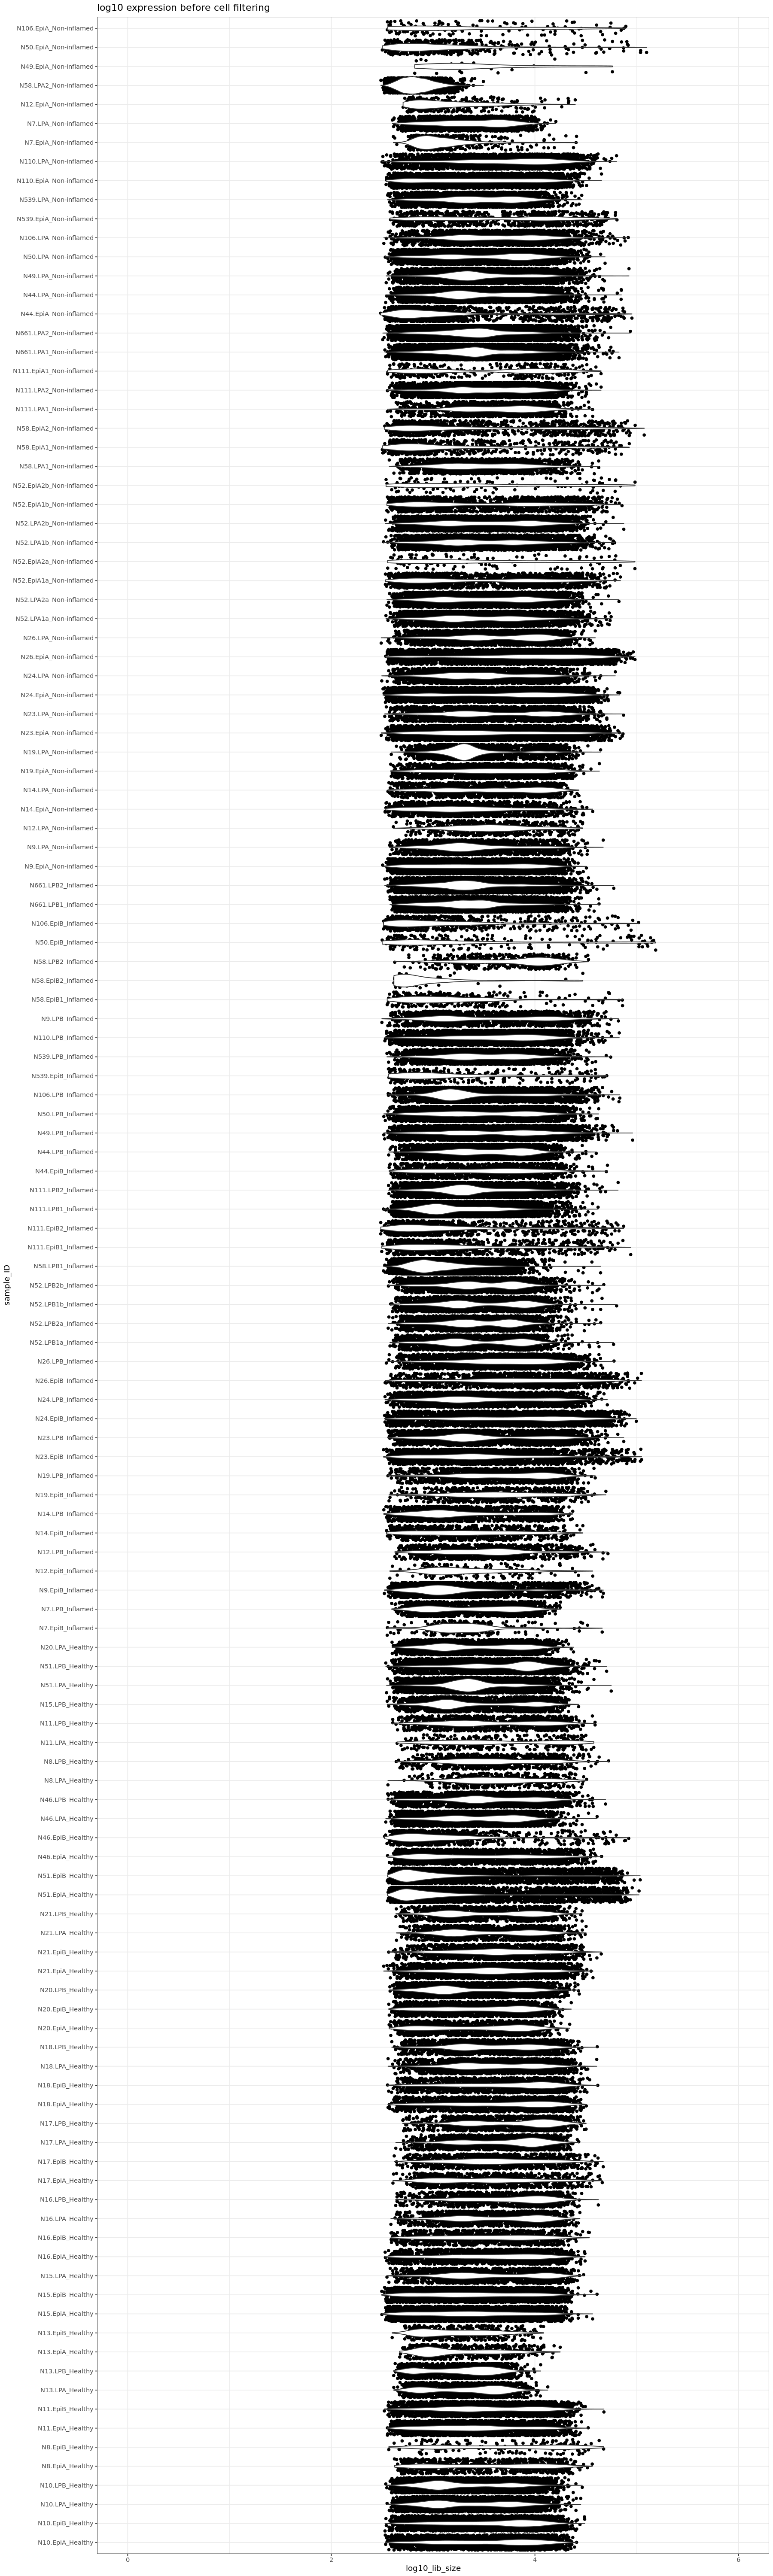

In [242]:
# visualize expression before any filtering
options(repr.plot.width=15,repr.plot.height=50)
df <- data.frame(log10_lib_size = log10(anno_cells$total_counts_raw +1)
                 ,sample_ID = anno_cells$sample_ID
)
df$sample_ID <- factor(df$sample_ID, levels = unique(df$sample_ID))
print(str(df))

print(ggplot(data = df,aes(x = sample_ID,y = log10_lib_size)
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression before cell filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()
)
rm(df)

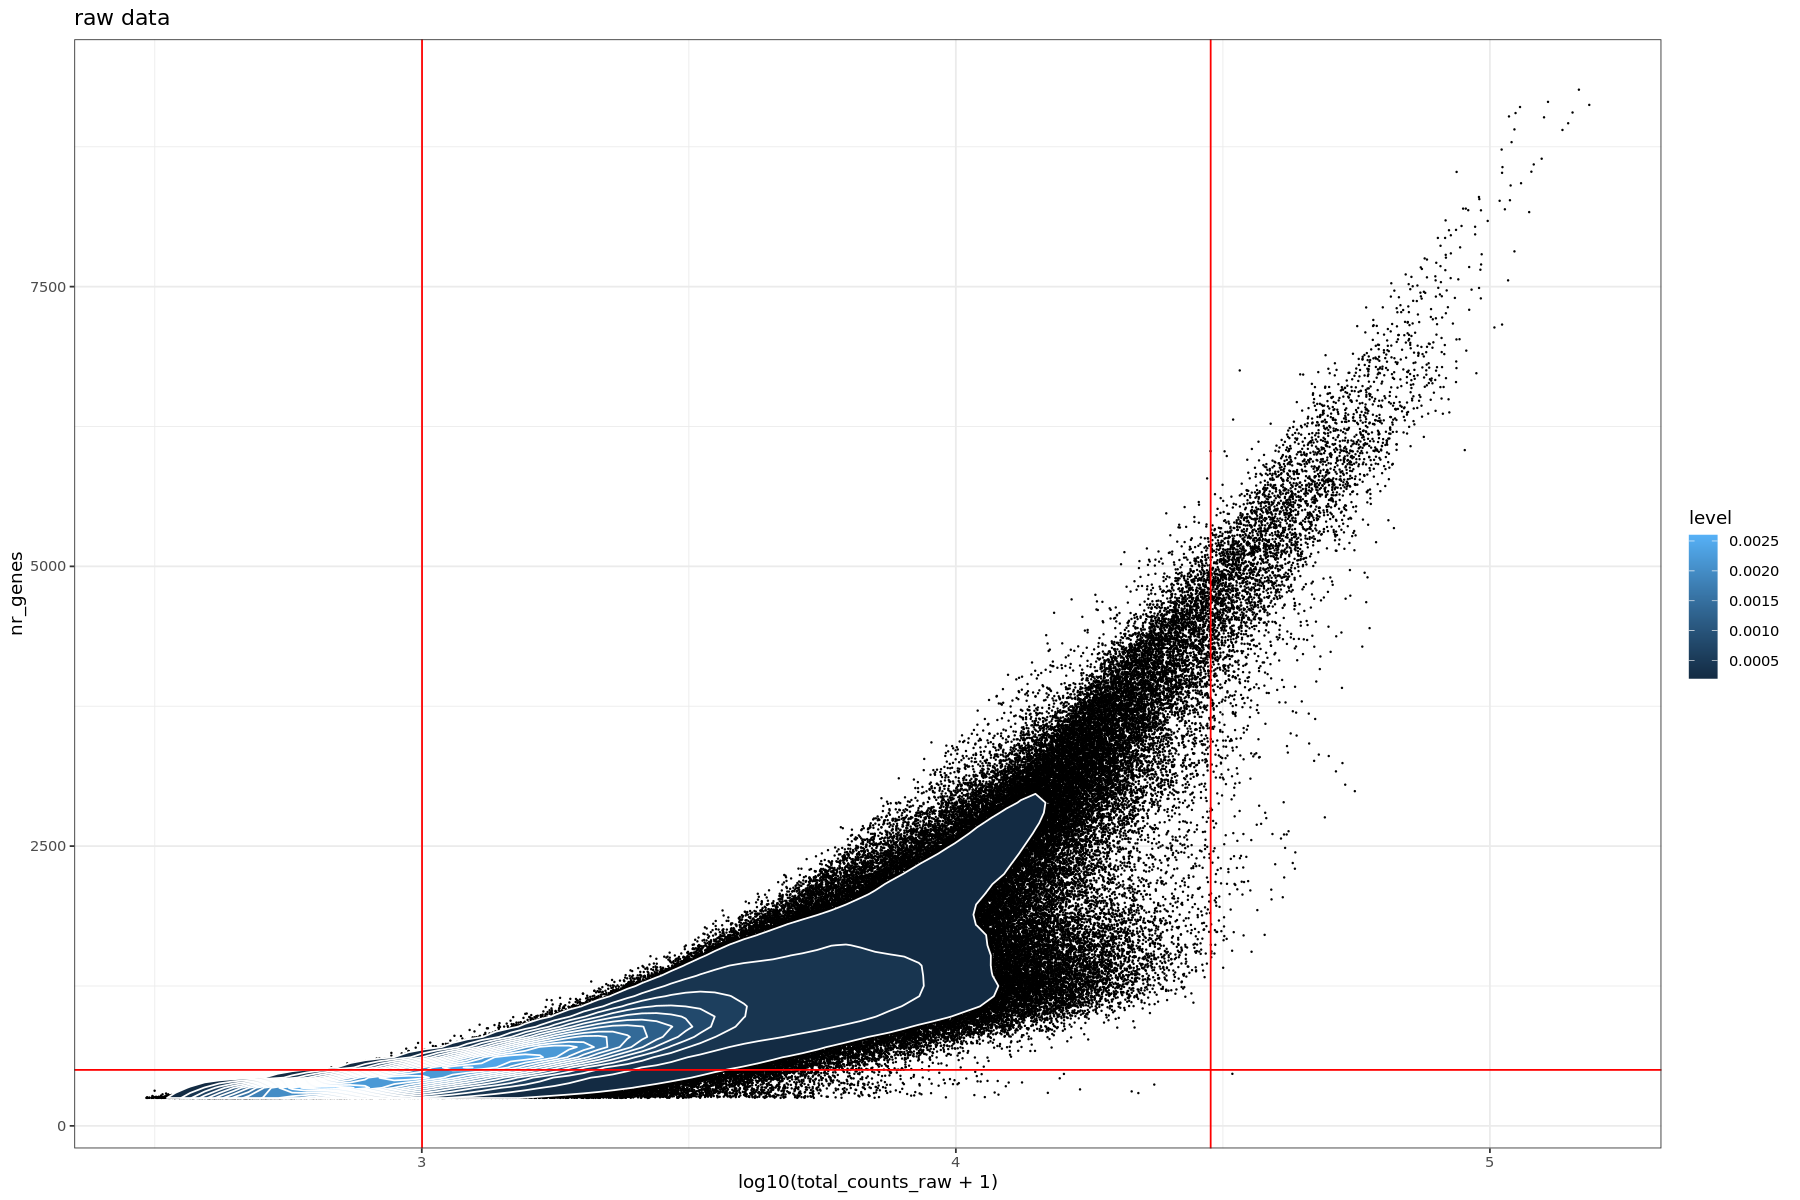

In [243]:
# plot log10 total counts vs nr genes
options(repr.plot.width=15,repr.plot.height=10)
print(ggplot(data = anno_cells,aes(x = log10(total_counts_raw +1),y = nr_genes)
) +
        geom_point(size = 0.05) +
        stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
        #geom_abline(intercept = -10500
        #            ,slope = 3000
        #            , col = "red"
        #) +
        geom_vline(xintercept = log10(c(1000,30000)+1)
                   ,col = "red") +
        geom_hline(yintercept = 500
                   ,col = "red") +
        ggtitle("raw data")+
        theme_bw()
      )

In [244]:
#apply cell filters
anno_cells_cf <- anno_cells[anno_cells$cell_filter,]
print("before cell filtering:")
cat("dim(anno_cells)", dim(anno_cells),"\n")
print("after cell filtering:")
cat("dim(anno_cells_cf)", dim(anno_cells_cf),"\n")

[1] "before cell filtering:"
dim(anno_cells) 365492 16 
[1] "after cell filtering:"
dim(anno_cells_cf) 263014 16 


In [245]:
# save cell number in anno_samples
for(sample in unique(anno_cells$sample_ID)){
        
        my_anno <- anno_cells[anno_cells$sample_ID == sample,]
        my_anno_cf <- anno_cells_cf[anno_cells_cf$sample_ID == sample,]
        
        anno_samples$nr_cells_raw[anno_samples$sample_ID == sample] <- nrow(my_anno)
        anno_samples$nr_cells_cf[anno_samples$sample_ID == sample] <- nrow(my_anno_cf)
}
cat("anno_samples\n\n")
print(anno_samples)

anno_samples

                  sample_ID patient_ID       region health_status nr_cells_raw
1          N10.EpiA_Healthy        N10      Healthy       Healthy         2725
2          N10.EpiB_Healthy        N10      Healthy       Healthy         4181
3           N10.LPA_Healthy        N10      Healthy       Healthy         4635
4           N10.LPB_Healthy        N10      Healthy       Healthy         5102
5           N8.EpiA_Healthy         N8      Healthy       Healthy          778
6           N8.EpiB_Healthy         N8      Healthy       Healthy          164
7            N8.LPA_Healthy         N8      Healthy       Healthy          465
8            N8.LPB_Healthy         N8      Healthy       Healthy          817
9          N11.EpiA_Healthy        N11      Healthy       Healthy         2621
10         N11.EpiB_Healthy        N11      Healthy       Healthy         2758
11          N11.LPA_Healthy        N11      Healthy       Healthy          320
12          N11.LPB_Healthy        N11

In [246]:
# subset counts
print("counts dim:")
print("before cell filtering:")
print(dim(counts_cf))
print("subset counts")
counts_cf <- counts_cf[,anno_cells_cf$cell_ID]
print("after cell filtering:")
print(dim(counts_cf))

[1] "counts dim:"
[1] "before cell filtering:"
[1]  21784 365492
[1] "subset counts"
[1] "after cell filtering:"
[1]  21784 263014


In [247]:
str(anno_cells_cf)

'data.frame':	263014 obs. of  16 variables:
 $ sample_ID             : chr  "N10.EpiA_Healthy" "N10.EpiA_Healthy" "N10.EpiA_Healthy" "N10.EpiA_Healthy" ...
 $ cell_type_original    : chr  "Stem" "Stem" "Stem" "Stem" ...
 $ tissue_type           : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type             : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_ID               : chr  "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
 $ region                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ total_counts_raw      : num  2995 6527 9262 13631 21207 ...
 $ nr_genes              : int  1119 1534 2042 2666 3290 1773 1203 2477 3121 3534 ...
 $ counts_upper_threshold: num  30000 30000 30000 30000 30000 30000 30000 30000 30000 30000 ...
 $ counts_lower_threshold: num  1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 ...
 $ genes_lower_threshold : num  300 300 300 300 300 300 3

In [248]:
# visualize expression after cell filtering and before population size filtering
df <- data.frame(log10_lib_size = log10(anno_cells_cf$total_counts_raw +1)
                 ,sample_ID = 
                 anno_cells_cf$sample_ID
)
df$sample_ID <- factor(df$sample_ID, levels = unique(df$sample_ID))
print(str(df))

'data.frame':	263014 obs. of  2 variables:
 $ log10_lib_size: num  3.48 3.81 3.97 4.13 4.33 ...
 $ sample_ID     : Factor w/ 133 levels "N10.EpiA_Healthy",..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


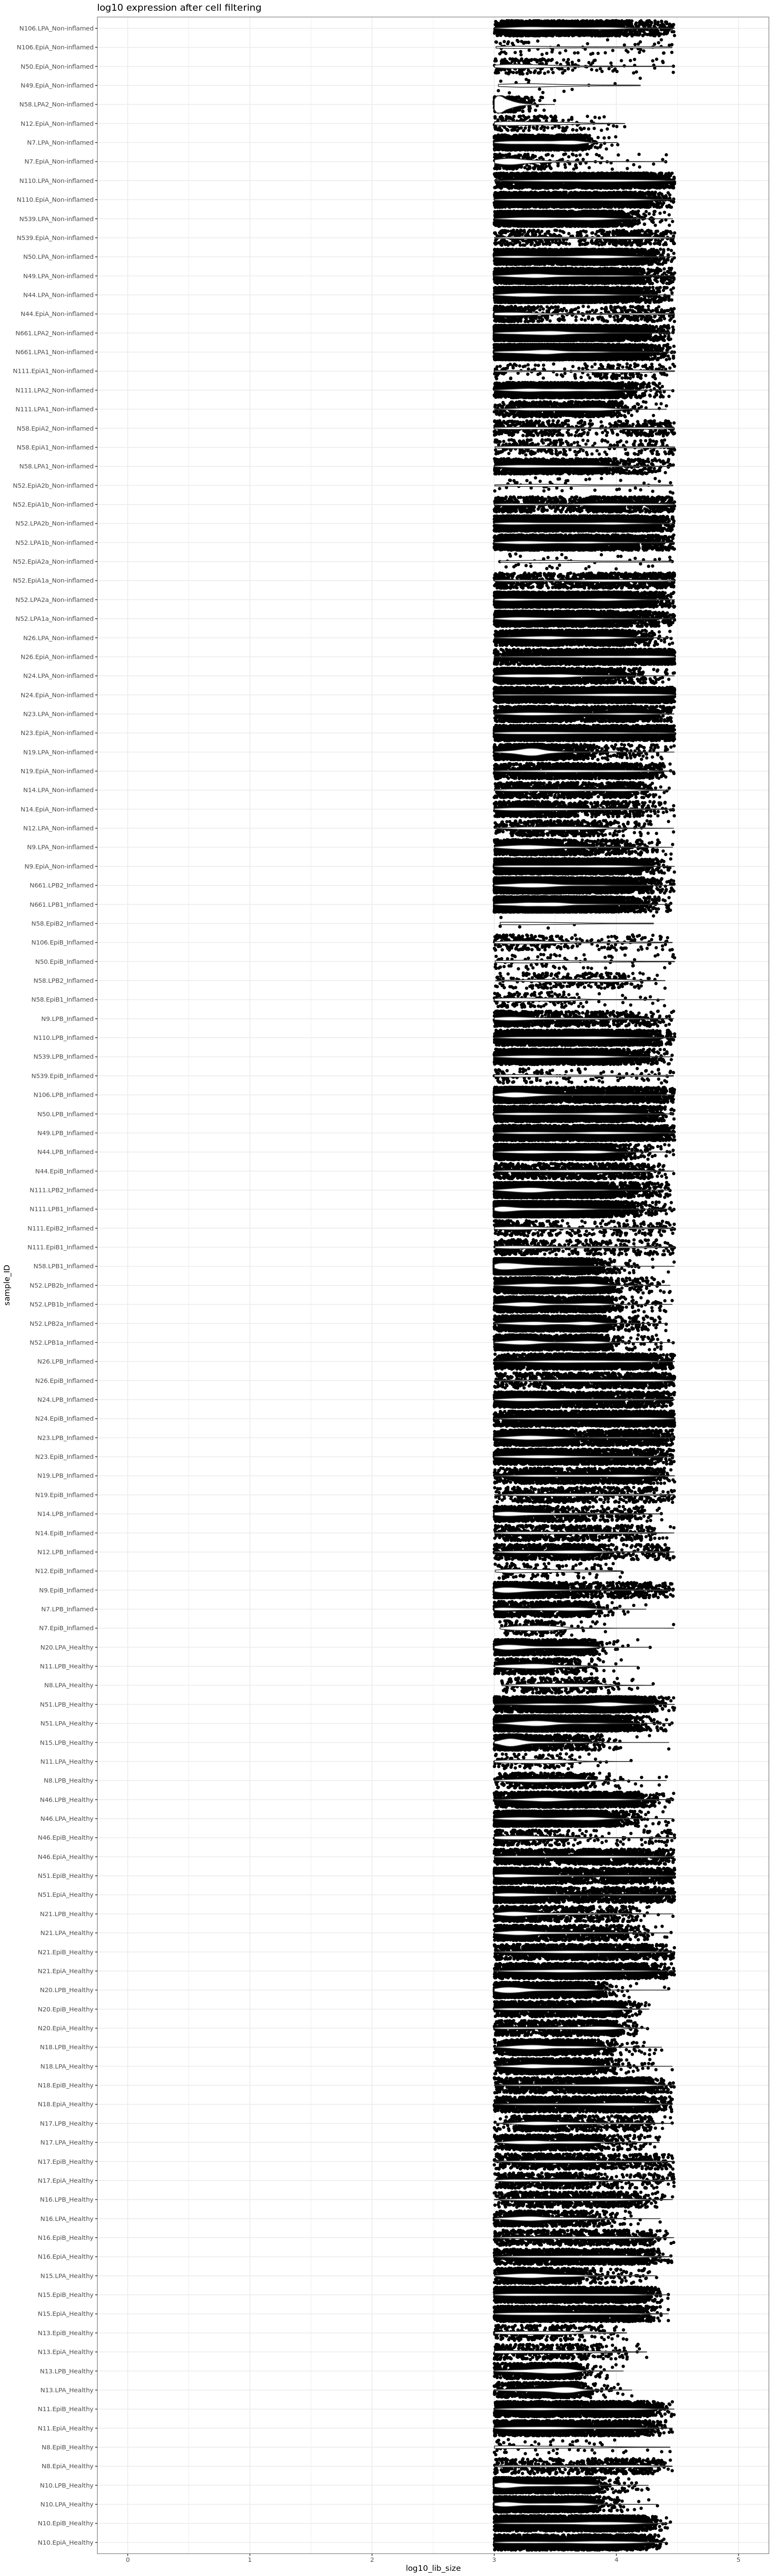

In [249]:
options(repr.plot.width=15,repr.plot.height=50)
print(ggplot(data = df,aes(x = sample_ID,y = log10_lib_size)) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after cell filtering") +
        coord_flip() +
        ylim(c(0,5))+
        theme_bw() 
        #scale_y_continuous()
)
rm(df)

In [250]:
anno_samples_cf <- anno_samples %>% 
  arrange(region)

anno_genes_cf <- anno_genes

In [251]:
unique(anno_cells_cf$sample_ID)

[1] "N10.EpiA_Healthy"        "N10.EpiB_Healthy"       
  [3] "N10.LPA_Healthy"         "N10.LPB_Healthy"        
  [5] "N8.EpiA_Healthy"         "N8.EpiB_Healthy"        
  [7] "N11.EpiA_Healthy"        "N11.EpiB_Healthy"       
  [9] "N13.LPA_Healthy"         "N13.LPB_Healthy"        
 [11] "N13.EpiA_Healthy"        "N13.EpiB_Healthy"       
 [13] "N15.EpiA_Healthy"        "N15.EpiB_Healthy"       
 [15] "N15.LPA_Healthy"         "N16.EpiA_Healthy"       
 [17] "N16.EpiB_Healthy"        "N16.LPA_Healthy"        
 [19] "N16.LPB_Healthy"         "N17.EpiA_Healthy"       
 [21] "N17.EpiB_Healthy"        "N17.LPA_Healthy"        
 [23] "N17.LPB_Healthy"         "N18.EpiA_Healthy"       
 [25] "N18.EpiB_Healthy"        "N18.LPA_Healthy"        
 [27] "N18.LPB_Healthy"         "N20.EpiA_Healthy"       
 [29] "N20.EpiB_Healthy"        "N20.LPB_Healthy"        
 [31] "N21.EpiA_Healthy"        "N21.EpiB_Healthy"       
 [33] "N21.LPA_Healthy"         "N21.LPB_Healthy"        
 [35] "N51.EpiA_Healthy"        "N51.EpiB_Healthy"       
 [37] "N46.EpiA_Healthy"        "N46.EpiB_Healthy"       
 [39] "N46.LPA_Healthy"         "N46.LPB_Healthy"        
 [41] "N8.LPB_Healthy"          "N11.LPA_Healthy"        
 [43] "N15.LPB_Healthy"         "N51.LPA_Healthy"        
 [45] "N51.LPB_Healthy"         "N8.LPA_Healthy"         
 [47] "N11.LPB_Healthy"         "N20.LPA_Healthy"        
 [49] "N7.EpiB_Inflamed"        "N7.LPB_Inflamed"        
 [51] "N9.EpiB_Inflamed"        "N12.EpiB_Inflamed"      
 [53] "N12.LPB_Inflamed"        "N14.EpiB_Inflamed"      
 [55] "N14.LPB_Inflamed"        "N19.EpiB_Inflamed"      
 [57] "N19.LPB_Inflamed"        "N23.EpiB_Inflamed"      
 [59] "N23.LPB_Inflamed"        "N24.EpiB_Inflamed"      
 [61] "N24.LPB_Inflamed"        "N26.EpiB_Inflamed"      
 [63] "N26.LPB_Inflamed"        "N52.LPB1a_Inflamed"     
 [65] "N52.LPB2a_Inflamed"      "N52.LPB1b_Inflamed"     
 [67] "N52.LPB2b_Inflamed"      "N58.LPB1_Inflamed"      
 [69] "N111.EpiB1_Inflamed"     "N111.EpiB2_Inflamed"    
 [71] "N111.LPB1_Inflamed"      "N111.LPB2_Inflamed"     
 [73] "N44.EpiB_Inflamed"       "N44.LPB_Inflamed"       
 [75] "N49.LPB_Inflamed"        "N50.LPB_Inflamed"       
 [77] "N106.LPB_Inflamed"       "N539.EpiB_Inflamed"     
 [79] "N539.LPB_Inflamed"       "N110.LPB_Inflamed"      
 [81] "N9.LPB_Inflamed"         "N58.EpiB1_Inflamed"     
 [83] "N58.LPB2_Inflamed"       "N50.EpiB_Inflamed"      
 [85] "N106.EpiB_Inflamed"      "N58.EpiB2_Inflamed"     
 [87] "N661.LPB1_Inflamed"      "N661.LPB2_Inflamed"     
 [89] "N9.EpiA_Non-inflamed"    "N9.LPA_Non-inflamed"    
 [91] "N12.LPA_Non-inflamed"    "N14.EpiA_Non-inflamed"  
 [93] "N14.LPA_Non-inflamed"    "N19.EpiA_Non-inflamed"  
 [95] "N19.LPA_Non-inflamed"    "N23.EpiA_Non-inflamed"  
 [97] "N23.LPA_Non-inflamed"    "N24.EpiA_Non-inflamed"  
 [99] "N24.LPA_Non-inflamed"    "N26.EpiA_Non-inflamed"  
[101] "N26.LPA_Non-inflamed"    "N52.LPA1a_Non-inflamed" 
[103] "N52.LPA2a_Non-inflamed"  "N52.EpiA1a_Non-inflamed"
[105] "N52.EpiA2a_Non-inflamed" "N52.LPA1b_Non-inflamed" 
[107] "N52.LPA2b_Non-inflamed"  "N52.EpiA1b_Non-inflamed"
[109] "N52.EpiA2b_Non-inflamed" "N58.LPA1_Non-inflamed"  
[111] "N58.EpiA1_Non-inflamed"  "N58.EpiA2_Non-inflamed" 
[113] "N111.LPA1_Non-inflamed"  "N111.LPA2_Non-inflamed" 
[115] "N111.EpiA1_Non-inflamed" "N661.LPA1_Non-inflamed" 
[117] "N661.LPA2_Non-inflamed"  "N44.EpiA_Non-inflamed"  
[119] "N44.LPA_Non-inflamed"    "N49.LPA_Non-inflamed"   
[121] "N50.LPA_Non-inflamed"    "N539.EpiA_Non-inflamed" 
[123] "N539.LPA_Non-inflamed"   "N110.EpiA_Non-inflamed" 
[125] "N110.LPA_Non-inflamed"   "N7.EpiA_Non-inflamed"   
[127] "N7.LPA_Non-inflamed"     "N12.EpiA_Non-inflamed"  
[129] "N58.LPA2_Non-inflamed"   "N49.EpiA_Non-inflamed"  
[131] "N50.EpiA_Non-inflamed"   "N106.EpiA_Non-inflamed" 
[133] "N106.LPA_Non-inflamed"

In [252]:
unique(anno_cells_cf$cell_type)

[1] "Epithelial"  "Fibroblasts" "Endothelial" "Glia"        "Myeloid"    
[6] "CD69"        "T_cells"     "Plasma"      "B_cells"

In [253]:
unique(anno_samples_cf$sample_ID)

[1] "N10.EpiA_Healthy"        "N10.EpiB_Healthy"       
  [3] "N10.LPA_Healthy"         "N10.LPB_Healthy"        
  [5] "N8.EpiA_Healthy"         "N8.EpiB_Healthy"        
  [7] "N8.LPA_Healthy"          "N8.LPB_Healthy"         
  [9] "N11.EpiA_Healthy"        "N11.EpiB_Healthy"       
 [11] "N11.LPA_Healthy"         "N11.LPB_Healthy"        
 [13] "N13.LPA_Healthy"         "N13.LPB_Healthy"        
 [15] "N13.EpiA_Healthy"        "N13.EpiB_Healthy"       
 [17] "N15.EpiA_Healthy"        "N15.EpiB_Healthy"       
 [19] "N15.LPA_Healthy"         "N15.LPB_Healthy"        
 [21] "N16.EpiA_Healthy"        "N16.EpiB_Healthy"       
 [23] "N16.LPA_Healthy"         "N16.LPB_Healthy"        
 [25] "N17.EpiA_Healthy"        "N17.EpiB_Healthy"       
 [27] "N17.LPA_Healthy"         "N17.LPB_Healthy"        
 [29] "N18.EpiA_Healthy"        "N18.EpiB_Healthy"       
 [31] "N18.LPA_Healthy"         "N18.LPB_Healthy"        
 [33] "N20.EpiA_Healthy"        "N20.EpiB_Healthy"       
 [35] "N20.LPA_Healthy"         "N20.LPB_Healthy"        
 [37] "N21.EpiA_Healthy"        "N21.EpiB_Healthy"       
 [39] "N21.LPA_Healthy"         "N21.LPB_Healthy"        
 [41] "N51.LPA_Healthy"         "N51.LPB_Healthy"        
 [43] "N51.EpiA_Healthy"        "N51.EpiB_Healthy"       
 [45] "N46.EpiA_Healthy"        "N46.EpiB_Healthy"       
 [47] "N46.LPA_Healthy"         "N46.LPB_Healthy"        
 [49] "N7.EpiB_Inflamed"        "N7.LPB_Inflamed"        
 [51] "N9.EpiB_Inflamed"        "N9.LPB_Inflamed"        
 [53] "N12.EpiB_Inflamed"       "N12.LPB_Inflamed"       
 [55] "N14.EpiB_Inflamed"       "N14.LPB_Inflamed"       
 [57] "N19.EpiB_Inflamed"       "N19.LPB_Inflamed"       
 [59] "N23.EpiB_Inflamed"       "N23.LPB_Inflamed"       
 [61] "N24.EpiB_Inflamed"       "N24.LPB_Inflamed"       
 [63] "N26.EpiB_Inflamed"       "N26.LPB_Inflamed"       
 [65] "N52.LPB1a_Inflamed"      "N52.LPB2a_Inflamed"     
 [67] "N52.LPB1b_Inflamed"      "N52.LPB2b_Inflamed"     
 [69] "N58.EpiB1_Inflamed"      "N58.EpiB2_Inflamed"     
 [71] "N58.LPB1_Inflamed"       "N58.LPB2_Inflamed"      
 [73] "N111.EpiB1_Inflamed"     "N111.EpiB2_Inflamed"    
 [75] "N111.LPB1_Inflamed"      "N111.LPB2_Inflamed"     
 [77] "N44.EpiB_Inflamed"       "N44.LPB_Inflamed"       
 [79] "N49.LPB_Inflamed"        "N50.EpiB_Inflamed"      
 [81] "N50.LPB_Inflamed"        "N106.EpiB_Inflamed"     
 [83] "N106.LPB_Inflamed"       "N539.EpiB_Inflamed"     
 [85] "N539.LPB_Inflamed"       "N110.LPB_Inflamed"      
 [87] "N661.LPB1_Inflamed"      "N661.LPB2_Inflamed"     
 [89] "N7.EpiA_Non-inflamed"    "N7.LPA_Non-inflamed"    
 [91] "N9.EpiA_Non-inflamed"    "N9.LPA_Non-inflamed"    
 [93] "N12.EpiA_Non-inflamed"   "N12.LPA_Non-inflamed"   
 [95] "N14.EpiA_Non-inflamed"   "N14.LPA_Non-inflamed"   
 [97] "N19.EpiA_Non-inflamed"   "N19.LPA_Non-inflamed"   
 [99] "N23.EpiA_Non-inflamed"   "N23.LPA_Non-inflamed"   
[101] "N24.EpiA_Non-inflamed"   "N24.LPA_Non-inflamed"   
[103] "N26.EpiA_Non-inflamed"   "N26.LPA_Non-inflamed"   
[105] "N52.LPA1a_Non-inflamed"  "N52.LPA2a_Non-inflamed" 
[107] "N52.EpiA1a_Non-inflamed" "N52.EpiA2a_Non-inflamed"
[109] "N52.LPA1b_Non-inflamed"  "N52.LPA2b_Non-inflamed" 
[111] "N52.EpiA1b_Non-inflamed" "N52.EpiA2b_Non-inflamed"
[113] "N58.LPA1_Non-inflamed"   "N58.LPA2_Non-inflamed"  
[115] "N58.EpiA1_Non-inflamed"  "N58.EpiA2_Non-inflamed" 
[117] "N111.LPA1_Non-inflamed"  "N111.LPA2_Non-inflamed" 
[119] "N111.EpiA1_Non-inflamed" "N661.LPA1_Non-inflamed" 
[121] "N661.LPA2_Non-inflamed"  "N44.EpiA_Non-inflamed"  
[123] "N44.LPA_Non-inflamed"    "N49.EpiA_Non-inflamed"  
[125] "N49.LPA_Non-inflamed"    "N50.EpiA_Non-inflamed"  
[127] "N50.LPA_Non-inflamed"    "N106.EpiA_Non-inflamed" 
[129] "N106.LPA_Non-inflamed"   "N539.EpiA_Non-inflamed" 
[131] "N539.LPA_Non-inflamed"   "N110.EpiA_Non-inflamed" 
[133] "N110.LPA_Non-inflamed"

## Filter cell types

Cell types which have too few cells (less than 5 cells) per sample or are present in too few samples (less than in 30 samples) will be filtered out.

- **INPUT:**
    - ```counts_cf.RData``` 
    - ```anno_cells_cf.RData```
    - ```anno_samples_cf.RData```
    - ```anno_genes_cf.RData```
    - ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
- **NOTES:**

    The '_ctf' ending in the file names stands for cell type filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf.RData``` 
    -  ```anno_cells_cf_ctf.RData``` 
    -  ```anno_samples_cf_ctf.RData``` 
    -  ```anno_genes_cf_ctf.RData``` 

In [254]:
# load cell relabelling file
print("load cell_relabelling")

file="cell_relabelling.csv"
cell_relabelling <- read.csv(file = "./rdata/cell_relabelling.csv", sep = ";")
rownames(cell_relabelling) <- cell_relabelling$cell_type_original
print(str(cell_relabelling))

[1] "load cell_relabelling"
'data.frame':	51 obs. of  6 variables:
 $ cell_type_original      : chr  "Stem" "TA 1" "TA 2" "Cycling TA" ...
 $ tissue_type             : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type_original_color: chr  "#CB4335" "#CB4335" "#CB4335" "#CB4335" ...
 $ cell_type_color         : chr  "#CB4335" "#CB4335" "#CB4335" "#CB4335" ...
 $ population_shape        : int  19 19 19 19 19 19 19 19 19 19 ...
 $ cell_type               : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
NULL


In [255]:
# thresholds ####
threshold_celltype_size <- 5 # cells per celltype
print(paste("Celltype size filter: each cell type in each sample should have at least", threshold_celltype_size, "cells."))

[1] "Celltype size filter: each cell type in each sample should have at least 5 cells."


In [256]:
threshold_nr_samples <- 50 # nr of samples in which a cell type should be present
print(paste("Number of samples filter: each cell type should be present in at least", threshold_nr_samples, "samples."))

[1] "Number of samples filter: each cell type should be present in at least 50 samples."


In [257]:
# color scheme for celltypes
color_celltype <- cell_relabelling$cell_type_color[!duplicated(cell_relabelling$cell_type)]
names(color_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]
print(color_celltype)

 Epithelial Fibroblasts Endothelial        Glia     Myeloid        CD69 
  "#CB4335"   "#8E44AD"   "#5B2C6F"   "#C969DF"   "#F09040"   "#FF7300" 
    T_cells      Plasma     B_cells 
  "#4F92EE"   "#4FCCEE"   "#4FC384" 


In [258]:
# shape scheme for celltypes
shape_celltype <- cell_relabelling$population_shape[!duplicated(cell_relabelling$cell_type)]
names(shape_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]
print(shape_celltype)

 Epithelial Fibroblasts Endothelial        Glia     Myeloid        CD69 
         19          15          15          14          13          13 
    T_cells      Plasma     B_cells 
         12           9          14 


In [259]:
# sample scheme for sample IDs
shape_sample <- c(rep(1,48),rep(2,40),rep(3,45))
names(shape_sample) <- unique(anno_samples_cf$sample_ID)
print(shape_sample)

       N10.EpiA_Healthy        N10.EpiB_Healthy         N10.LPA_Healthy 
                      1                       1                       1 
        N10.LPB_Healthy         N8.EpiA_Healthy         N8.EpiB_Healthy 
                      1                       1                       1 
         N8.LPA_Healthy          N8.LPB_Healthy        N11.EpiA_Healthy 
                      1                       1                       1 
       N11.EpiB_Healthy         N11.LPA_Healthy         N11.LPB_Healthy 
                      1                       1                       1 
        N13.LPA_Healthy         N13.LPB_Healthy        N13.EpiA_Healthy 
                      1                       1                       1 
       N13.EpiB_Healthy        N15.EpiA_Healthy        N15.EpiB_Healthy 
                      1                       1                       1 
        N15.LPA_Healthy         N15.LPB_Healthy        N16.EpiA_Healthy 
                      1                       1    

In [260]:
# size scheme for sample IDs
class(anno_samples_cf)
size_sample <- c(rep(3,48),rep(3,40),rep(3,45))
names(size_sample) <- unique(anno_samples_cf$sample_ID)

print(size_sample)

[1] "data.frame"

       N10.EpiA_Healthy        N10.EpiB_Healthy         N10.LPA_Healthy 
                      3                       3                       3 
        N10.LPB_Healthy         N8.EpiA_Healthy         N8.EpiB_Healthy 
                      3                       3                       3 
         N8.LPA_Healthy          N8.LPB_Healthy        N11.EpiA_Healthy 
                      3                       3                       3 
       N11.EpiB_Healthy         N11.LPA_Healthy         N11.LPB_Healthy 
                      3                       3                       3 
        N13.LPA_Healthy         N13.LPB_Healthy        N13.EpiA_Healthy 
                      3                       3                       3 
       N13.EpiB_Healthy        N15.EpiA_Healthy        N15.EpiB_Healthy 
                      3                       3                       3 
        N15.LPA_Healthy         N15.LPB_Healthy        N16.EpiA_Healthy 
                      3                       3    

### Filter

In [261]:
# store threshold values in the cell annotation file
anno_cells_cf$threshold_celltype_size <- threshold_celltype_size

In [262]:
# calculate celltype size
for(sample in unique(anno_cells_cf$sample_ID)){
        idx_sample <- anno_cells_cf$sample_ID == sample
        
        for(celltype in unique(anno_cells_cf$cell_type)){
                idx_celltype <- anno_cells_cf$cell_type == celltype
                
                idx_sample_celltype <- idx_sample & idx_celltype
                
                anno_cells_cf$celltype_size_cf[idx_sample_celltype] <- nrow(anno_cells_cf[idx_sample_celltype,])
        }
}

In [263]:
# calculate celltype size filter
anno_cells_cf$celltype_size_filter <- anno_cells_cf$celltype_size_cf >= anno_cells_cf$threshold_celltype_size

In [264]:
unique(anno_cells_cf$cell_type)

[1] "Epithelial"  "Fibroblasts" "Endothelial" "Glia"        "Myeloid"    
[6] "CD69"        "T_cells"     "Plasma"      "B_cells"

In [265]:
# visualize nr_samples vs log10_nr_cells before filtering
df <-unique(data.frame(sample_ID = anno_cells_cf$sample_ID
                       ,cell_type = anno_cells_cf$cell_type
                )
            )
df$nr_cells <- sapply(1: nrow(df)
                      ,function(i){
                              my_sample <- df$sample_ID[i]
                              my_celltype <- df$cell_type[i]
                              nr_cells <- sum((anno_cells_cf$sample_ID == my_sample) & (anno_cells_cf$cell_type == my_celltype))
                              nr_cells
                      })
df$nr_samples <- sapply(1: nrow(df)
                        ,function(i){
                                my_celltype <- df$cell_type[i]
                                idx_celltype <- anno_cells_cf$cell_type == my_celltype
                                nr_samples <- length(unique(anno_cells_cf$sample_ID[idx_celltype]))
                                nr_samples
                        })

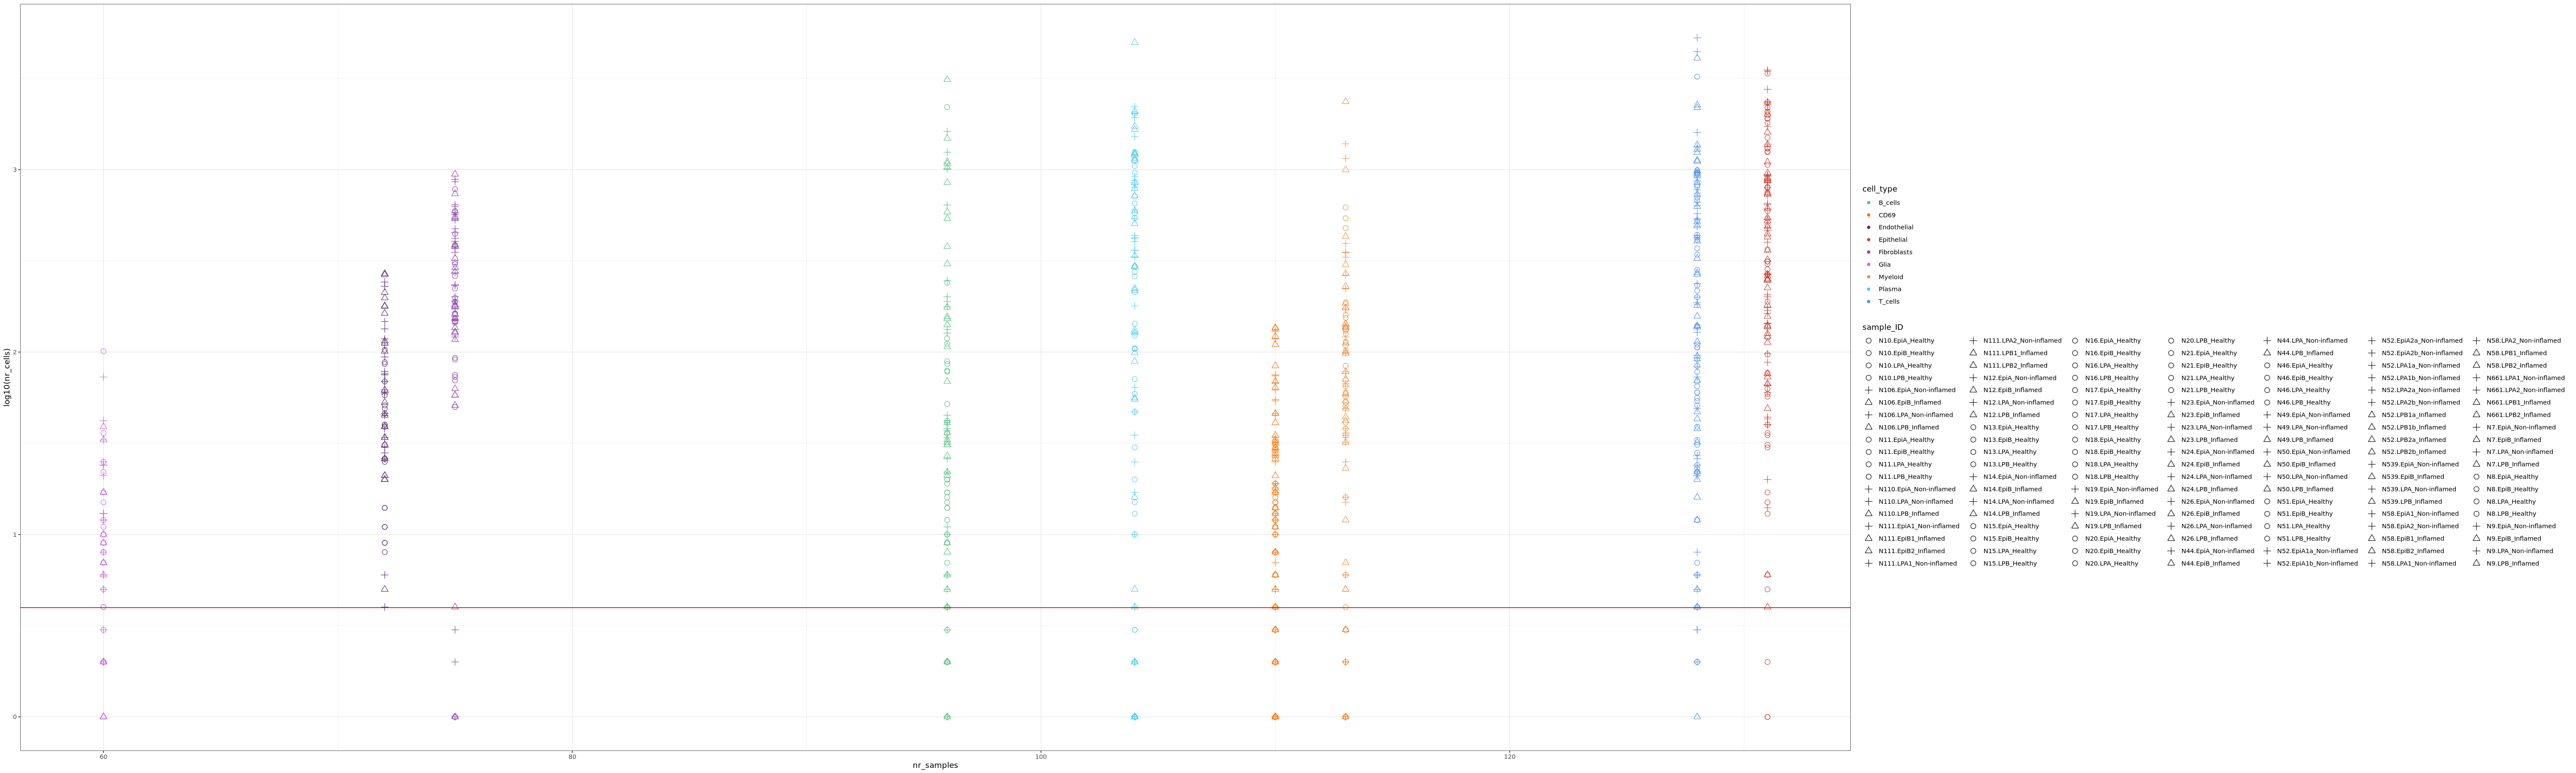

In [266]:
options(repr.plot.width=50,repr.plot.height=15)
ggplot(data = df
       ,aes(x=nr_samples
            ,y=log10(nr_cells)
            ,color=cell_type
            ,shape=sample_ID
            ,size = sample_ID
            )
       )+
        geom_point()+
        scale_color_manual(values=color_celltype)+
        scale_shape_manual(values=shape_sample)+
        scale_size_manual(values=size_sample)+
        geom_hline(yintercept = log10(threshold_celltype_size)-0.1
                   ,color = "red")+
        theme_bw()

In [267]:
# apply celltype size filter
# filter cell annotation file
anno_cells_cf_ctf <- anno_cells_cf[anno_cells_cf$celltype_size_filter,]
print("number of cells before celltype size filtering:")
print(nrow(anno_cells_cf))
print("number of cells after celltype size filtering:")
print(nrow(anno_cells_cf_ctf))

[1] "number of cells before celltype size filtering:"
[1] 263014
[1] "number of cells after celltype size filtering:"
[1] 262742


In [268]:
# filler count matrix
str(counts_cf)
counts_cf_ctf <- counts_cf[,anno_cells_cf$celltype_size_filter]
str(counts_cf_ctf)
rm(counts_cf)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:311695826] 15 46 72 77 89 631 715 742 745 755 ...
  ..@ p       : int [1:263015] 0 1119 2653 4695 7361 10651 12424 13627 16104 19225 ...
  ..@ Dim     : int [1:2] 21784 263014
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:21784] "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
  .. ..$ : chr [1:263014] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:311695826] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:311436233] 15 46 72 77 89 631 715 742 745 755 ...
  ..@ p       : int [1:262743] 0 1119 2653 4695 7361 10651 12424 13627 16104 19225 ...
  ..@ Dim     : int [1:2] 21784 262742
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:21784] "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
  .. ..$ : chr [1:262742] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA"

In [269]:
print("following cell types didn't pass the celltype size filter:")
for(sample in unique(anno_cells_cf_ctf$sample_ID)){
        print(sample)
        my_anno_cf <- anno_cells_cf[anno_cells_cf$sample_ID == sample,]
        print(table(my_anno_cf[!my_anno_cf$celltype_size_filter,"cell_type"]))
}

[1] "following cell types didn't pass the celltype size filter:"
[1] "N10.EpiA_Healthy"

Fibroblasts     Myeloid      Plasma 
          1           3           1 
[1] "N10.EpiB_Healthy"

Myeloid 
      3 
[1] "N10.LPA_Healthy"
< table of extent 0 >
[1] "N10.LPB_Healthy"
< table of extent 0 >
[1] "N8.EpiA_Healthy"

CD69 
   1 
[1] "N8.EpiB_Healthy"
< table of extent 0 >
[1] "N11.EpiA_Healthy"

Myeloid 
      2 
[1] "N11.EpiB_Healthy"

   CD69 Myeloid 
      4       1 
[1] "N13.LPA_Healthy"

CD69 
   2 
[1] "N13.LPB_Healthy"
< table of extent 0 >
[1] "N13.EpiA_Healthy"

CD69 
   1 
[1] "N13.EpiB_Healthy"

B_cells Myeloid T_cells 
      3       1       2 
[1] "N15.EpiA_Healthy"

Fibroblasts     Myeloid      Plasma 
          1           2           2 
[1] "N15.EpiB_Healthy"

Myeloid 
      3 
[1] "N15.LPA_Healthy"
< table of extent 0 >
[1] "N16.EpiA_Healthy"

Myeloid  Plasma 
      1       3 
[1] "N16.EpiB_Healthy"
< table of extent 0 >
[1] "N16.LPA_Healthy"
< table of extent 0 >
[1] "N16

### filter for being present in min number of samples

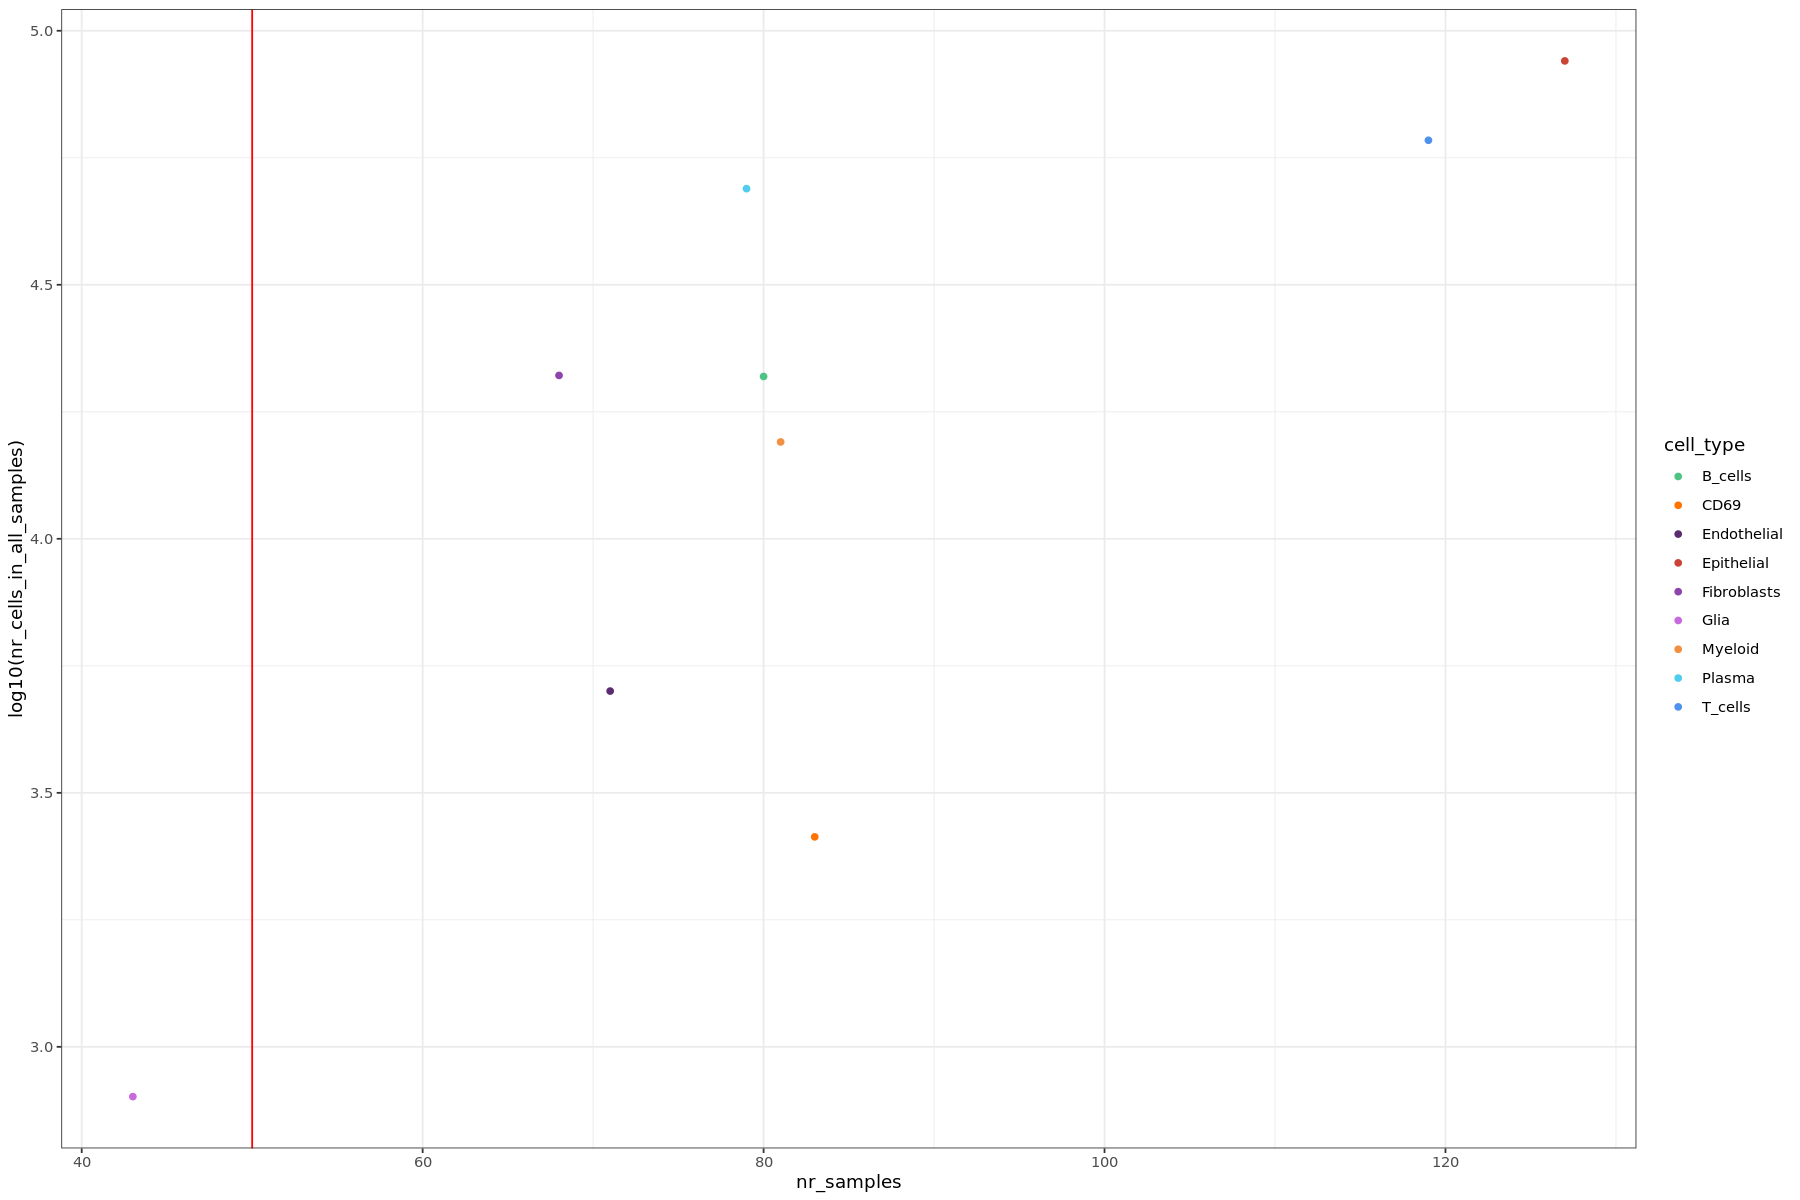

In [270]:
# visualize nr_samples vs log10_nr_cells_all_samples before filtering, different colors
options(repr.plot.width=15,repr.plot.height=10)
df <-unique(data.frame(cell_type = anno_cells_cf_ctf$cell_type))

df$nr_cells_in_all_samples <- sapply(1: nrow(df)
                      ,function(i){
                              my_celltype <- df$cell_type[i]
                              nr_cells <- sum(anno_cells_cf_ctf$cell_type == my_celltype)
                              nr_cells
                      })

df$nr_samples <- sapply(1: nrow(df)
                        ,function(i){
                                my_celltype <- df$cell_type[i]
                                idx_celltype <- anno_cells_cf_ctf$cell_type == my_celltype
                                nr_samples <- length(unique(anno_cells_cf_ctf$sample_ID[idx_celltype]))
                                nr_samples
                        })

rownames(df) <- df$cell_type

ggplot(data = df
       ,aes(x = nr_samples
            ,y = log10(nr_cells_in_all_samples)
            ,color = cell_type
       )
) +
        geom_point() +
        scale_color_manual(values = color_celltype) +
        geom_vline(xintercept = threshold_nr_samples
                   ,color = "red")+
        theme_bw()

# Filter underrepresented cell types

In [271]:
print(paste("filter out celltypes present in less than"
             ,threshold_nr_samples
             ,"samples"))
print("following celltypes didn' pass the filter")
bad_celltypes <- rownames(df)[df$nr_samples < threshold_nr_samples]
print(bad_celltypes)

[1] "filter out celltypes present in less than 50 samples"
[1] "following celltypes didn' pass the filter"
[1] "Glia"


In [272]:
str(counts_cf_ctf)
print("dim(counts_cf_ctf) before filtering")
print(dim(counts_cf_ctf))
counts_cf_ctf <- counts_cf_ctf[,!(anno_cells_cf_ctf$cell_type %in% bad_celltypes)]
print("dim(counts_cf_ctf) after filtering")
print(dim(counts_cf_ctf))
print("dim(anno_cells_cf_ctf) before filtering")
print(dim(anno_cells_cf_ctf))
anno_cells_cf_ctf <- anno_cells_cf_ctf[!(anno_cells_cf_ctf$cell_type %in% bad_celltypes),]
print("dim(anno_cells_cf_ctf) after filtering")
print(dim(anno_cells_cf_ctf))

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:311436233] 15 46 72 77 89 631 715 742 745 755 ...
  ..@ p       : int [1:262743] 0 1119 2653 4695 7361 10651 12424 13627 16104 19225 ...
  ..@ Dim     : int [1:2] 21784 262742
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:21784] "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
  .. ..$ : chr [1:262742] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:311436233] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()
[1] "dim(counts_cf_ctf) before filtering"
[1]  21784 262742
[1] "dim(counts_cf_ctf) after filtering"
[1]  21784 261944
[1] "dim(anno_cells_cf_ctf) before filtering"
[1] 262742     19
[1] "dim(anno_cells_cf_ctf) after filtering"
[1] 261944     19


In [273]:
str(counts_cf_ctf)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:310587570] 15 46 72 77 89 631 715 742 745 755 ...
  ..@ p       : int [1:261945] 0 1119 2653 4695 7361 10651 12424 13627 16104 19225 ...
  ..@ Dim     : int [1:2] 21784 261944
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:21784] "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
  .. ..$ : chr [1:261944] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:310587570] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()


In [274]:
# visualize expression after cell filtering and celltype size filtering
print("visualize expression after cell filtering and celltype size filtering")
df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf$total_counts_raw +1)
                 ,sample_ID = anno_cells_cf_ctf$sample_ID
)
df$sample_ID <- factor(df$sample_ID, levels = unique(df$sample_ID))
print(str(df))

[1] "visualize expression after cell filtering and celltype size filtering"
'data.frame':	261944 obs. of  2 variables:
 $ log10_lib_size: num  3.48 3.81 3.97 4.13 4.33 ...
 $ sample_ID     : Factor w/ 133 levels "N10.EpiA_Healthy",..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


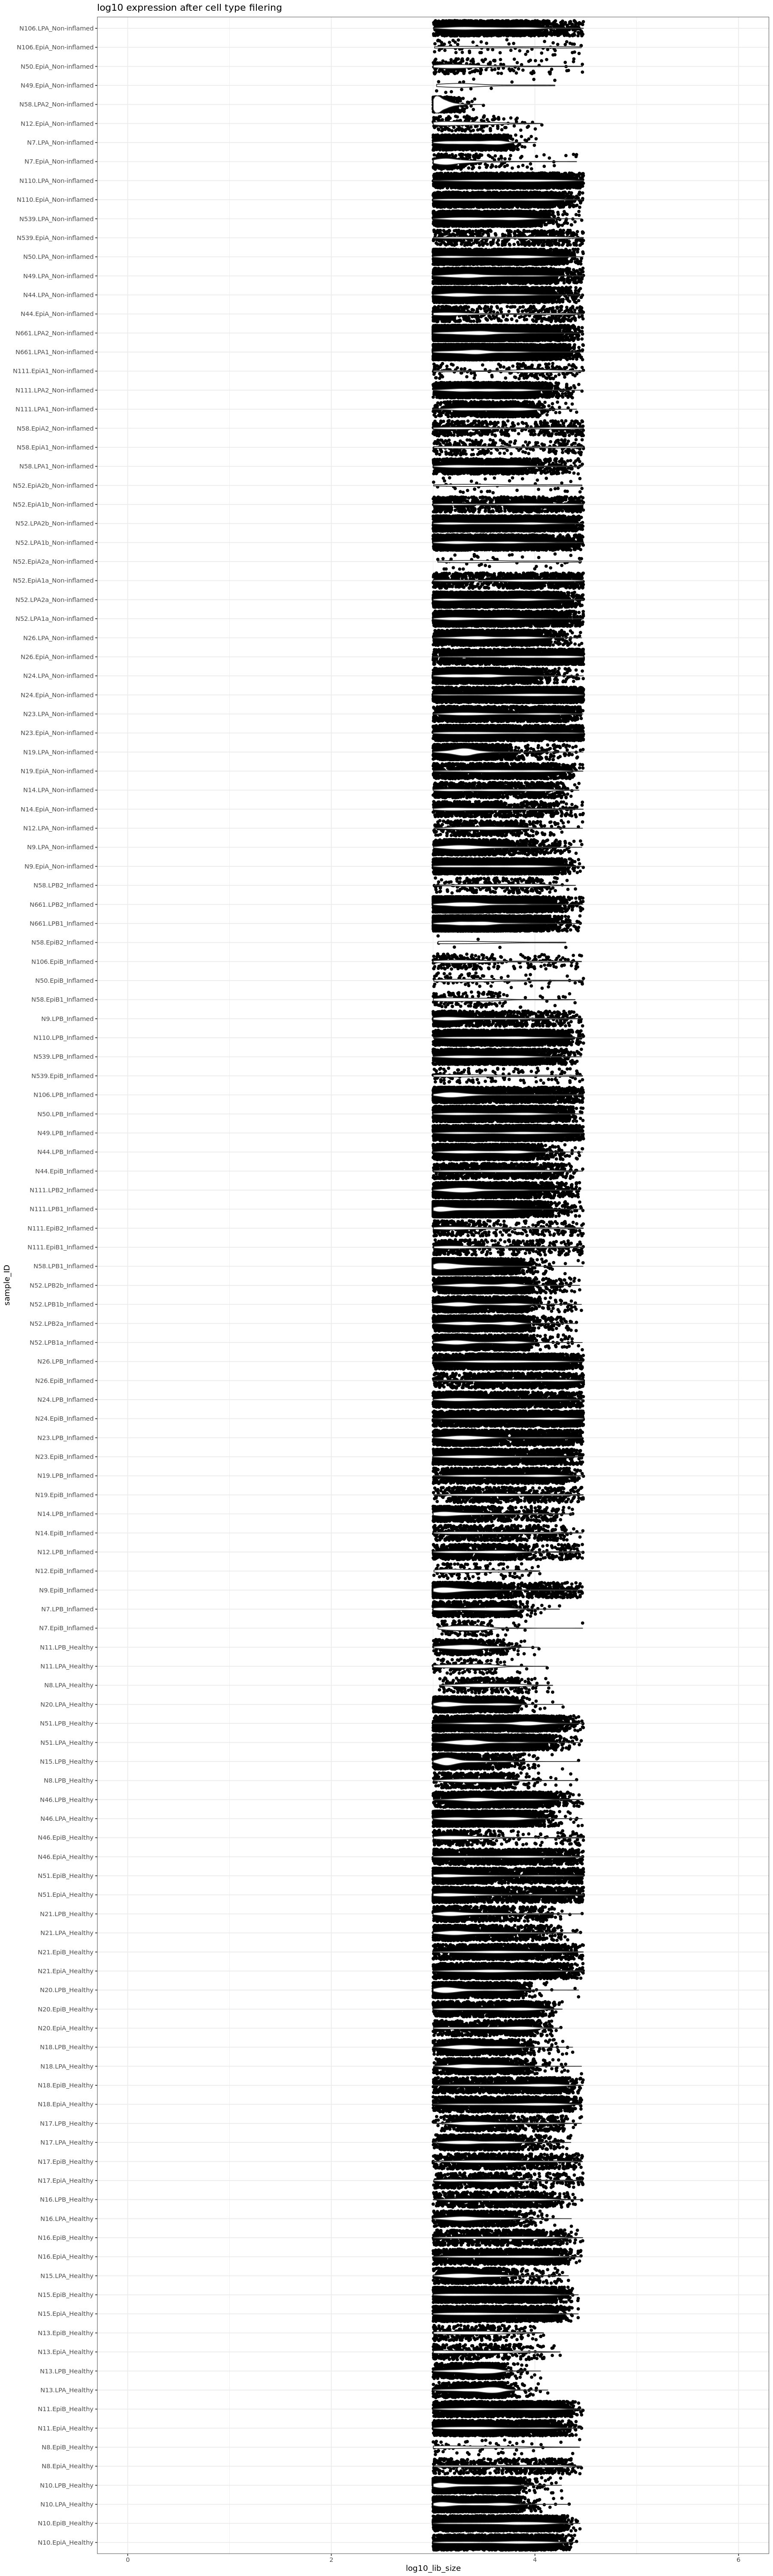

In [275]:
options(repr.plot.width=15,repr.plot.height=50)
ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after cell type filering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

In [276]:
# create anno_samples_cf_ctf
anno_samples_cf_ctf <- anno_samples_cf

In [277]:
# save cell number in anno_samples
for(sample in unique(anno_cells_cf_ctf$sample_ID)){
        
        my_anno_cf <- anno_cells_cf_ctf[anno_cells_cf_ctf$sample_ID == sample,]
        
        anno_samples_cf_ctf$nr_cells_cf_ctf[anno_samples_cf_ctf$sample_ID == sample] <- nrow(my_anno_cf)
}
print("anno_samples_cf_ctf")
print(anno_samples_cf_ctf)

[1] "anno_samples_cf_ctf"
                  sample_ID patient_ID       region health_status nr_cells_raw
1          N10.EpiA_Healthy        N10      Healthy       Healthy         2725
2          N10.EpiB_Healthy        N10      Healthy       Healthy         4181
3           N10.LPA_Healthy        N10      Healthy       Healthy         4635
4           N10.LPB_Healthy        N10      Healthy       Healthy         5102
5           N8.EpiA_Healthy         N8      Healthy       Healthy          778
6           N8.EpiB_Healthy         N8      Healthy       Healthy          164
7            N8.LPA_Healthy         N8      Healthy       Healthy          465
8            N8.LPB_Healthy         N8      Healthy       Healthy          817
9          N11.EpiA_Healthy        N11      Healthy       Healthy         2621
10         N11.EpiB_Healthy        N11      Healthy       Healthy         2758
11          N11.LPA_Healthy        N11      Healthy       Healthy          320
12          N11.LPB_Health

In [278]:
# create anno_gene_cf_ctf
anno_genes_cf_ctf <- anno_genes_cf

In [279]:
str(counts_cf_ctf)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:310587570] 15 46 72 77 89 631 715 742 745 755 ...
  ..@ p       : int [1:261945] 0 1119 2653 4695 7361 10651 12424 13627 16104 19225 ...
  ..@ Dim     : int [1:2] 21784 261944
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:21784] "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
  .. ..$ : chr [1:261944] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:310587570] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()


### export

In [280]:
# #save counts_cf_ctf.RData
# save(counts_cf_ctf, file = "counts_cf_ctf.RData")

# #save anno_cells_cf_ctf.RData
# save(anno_cells_cf_ctf, file = "anno_cells_cf_ctf.RData")

# #save anno_samples_cf_ctf.RData
# save(anno_samples_cf_ctf, file = "anno_samples_cf_ctf.RData")

# #save anno_genes_cf_ctf.RData
# save(anno_genes_cf_ctf, file = "anno_genes_cf_ctf.RData")

## Filter genes

Individual genes might be specific to certain cell types in cetrain health conditions. Here we will construct pseudo-bulk cell types (per sample) and filter out genes that have too low cumulative expression in these pseudo-bulks.

- **INPUT:**
    - ```counts_cf_ctf.RData``` 
    - ```anno_cells_cf_ctf.RData```
    - ```anno_samples_cf_ctf.RData```
    - ```anno_genes_cf_ctf.RData```
    - ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **NOTES:**

    The '_gf' ending in the file names stands for gene filter.
    
    
- **OUTPUT:**

    -  ```counts_cf_ctf_gf.RData```
    -  ```anno_cells_cf_ctf_gf.RData```
    -  ```anno_samples_cf_ctf_gf.RData```
    -  ```anno_genes_cf_ctf_gf.RData```

In [281]:
rownames(cell_relabelling) <- cell_relabelling$cell_type_original
print(str(cell_relabelling))

'data.frame':	51 obs. of  6 variables:
 $ cell_type_original      : chr  "Stem" "TA 1" "TA 2" "Cycling TA" ...
 $ tissue_type             : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type_original_color: chr  "#CB4335" "#CB4335" "#CB4335" "#CB4335" ...
 $ cell_type_color         : chr  "#CB4335" "#CB4335" "#CB4335" "#CB4335" ...
 $ population_shape        : int  19 19 19 19 19 19 19 19 19 19 ...
 $ cell_type               : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
NULL


In [282]:
# thresholds
threshold_sum_pseudobulkCellType_expr <- 5
print(paste("threshold_sum_pseudobulkCellType_expr: >", threshold_sum_pseudobulkCellType_expr))


[1] "threshold_sum_pseudobulkCellType_expr: > 5"


In [283]:
# color scheme for celltypes
color_celltype <- cell_relabelling$cell_type_color[!duplicated(cell_relabelling$cell_type)]
names(color_celltype) <- cell_relabelling$cell_type[!duplicated(cell_relabelling$cell_type)]

### process data

In [284]:
# construct pseudo sorted bulk

anno_cells_cf_ctf$cell_type_ID <- paste(anno_cells_cf_ctf$cell_type
                                        ,anno_cells_cf_ctf$sample_ID
                                        ,sep = "_"
)

In [285]:
cell_type_IDs <- unique(anno_cells_cf_ctf$cell_type_ID)
counts_raw_pseudobulkCellType <- as.data.frame(matrix(,nrow = nrow(counts_cf_ctf)
                                                    ,ncol = length(cell_type_IDs)
))

i <- 1
for(cell_type_ID in cell_type_IDs){
        #print(cell_type_ID)
        
        idx_cell_type_ID <- anno_cells_cf_ctf$cell_type_ID == cell_type_ID
        
        if(sum(idx_cell_type_ID) == 0){
                counts_raw_pseudobulkCellType[,i] <- 0
        } else if( sum(idx_cell_type_ID) == 1){
                counts_raw_pseudobulkCellType[,i] <- counts_cf_ctf[,idx_cell_type_ID]
        } else {
                counts_raw_pseudobulkCellType[,i] <- rowMeans(counts_cf_ctf[,idx_cell_type_ID])
        }
        
        i <- i+1
}

colnames(counts_raw_pseudobulkCellType) <- cell_type_IDs
rownames(counts_raw_pseudobulkCellType) <- rownames(counts_cf_ctf)
cat("str(counts_raw_pseudobulkCellType\n\n)")
print(str(counts_raw_pseudobulkCellType))

str(counts_raw_pseudobulkCellType

)'data.frame':	21784 obs. of  708 variables:
 $ Epithelial_N10.EpiA_Healthy       : num  0.00193 0 0 0.13678 0 ...
 $ Epithelial_N10.EpiB_Healthy       : num  0.00268 0.00119 0 0.12846 0 ...
 $ Epithelial_N10.LPA_Healthy        : num  0 0 0 0.1864 0.0339 ...
 $ Epithelial_N10.LPB_Healthy        : num  0 0 0 0.1948 0.0649 ...
 $ Epithelial_N8.EpiA_Healthy        : num  0 0 0 0.146 0 ...
 $ Epithelial_N8.EpiB_Healthy        : num  0 0 0 0.0635 0 ...
 $ Epithelial_N11.EpiA_Healthy       : num  0.00105 0 0 0.14316 0 ...
 $ Epithelial_N11.EpiB_Healthy       : num  0.00275 0 0 0.17003 0 ...
 $ Epithelial_N13.LPA_Healthy        : num  0 0 0 0.0563 0.0106 ...
 $ Epithelial_N13.LPB_Healthy        : num  0.00329 0 0 0.08224 0.00658 ...
 $ Epithelial_N13.EpiA_Healthy       : num  0 0 0 0.144 0 ...
 $ Epithelial_N13.EpiB_Healthy       : num  0 0 0 0.151 0 ...
 $ Epithelial_N15.EpiA_Healthy       : num  0 0 0.000503 0.167589 0 ...
 $ Epithelial_N15.EpiB_Healthy   

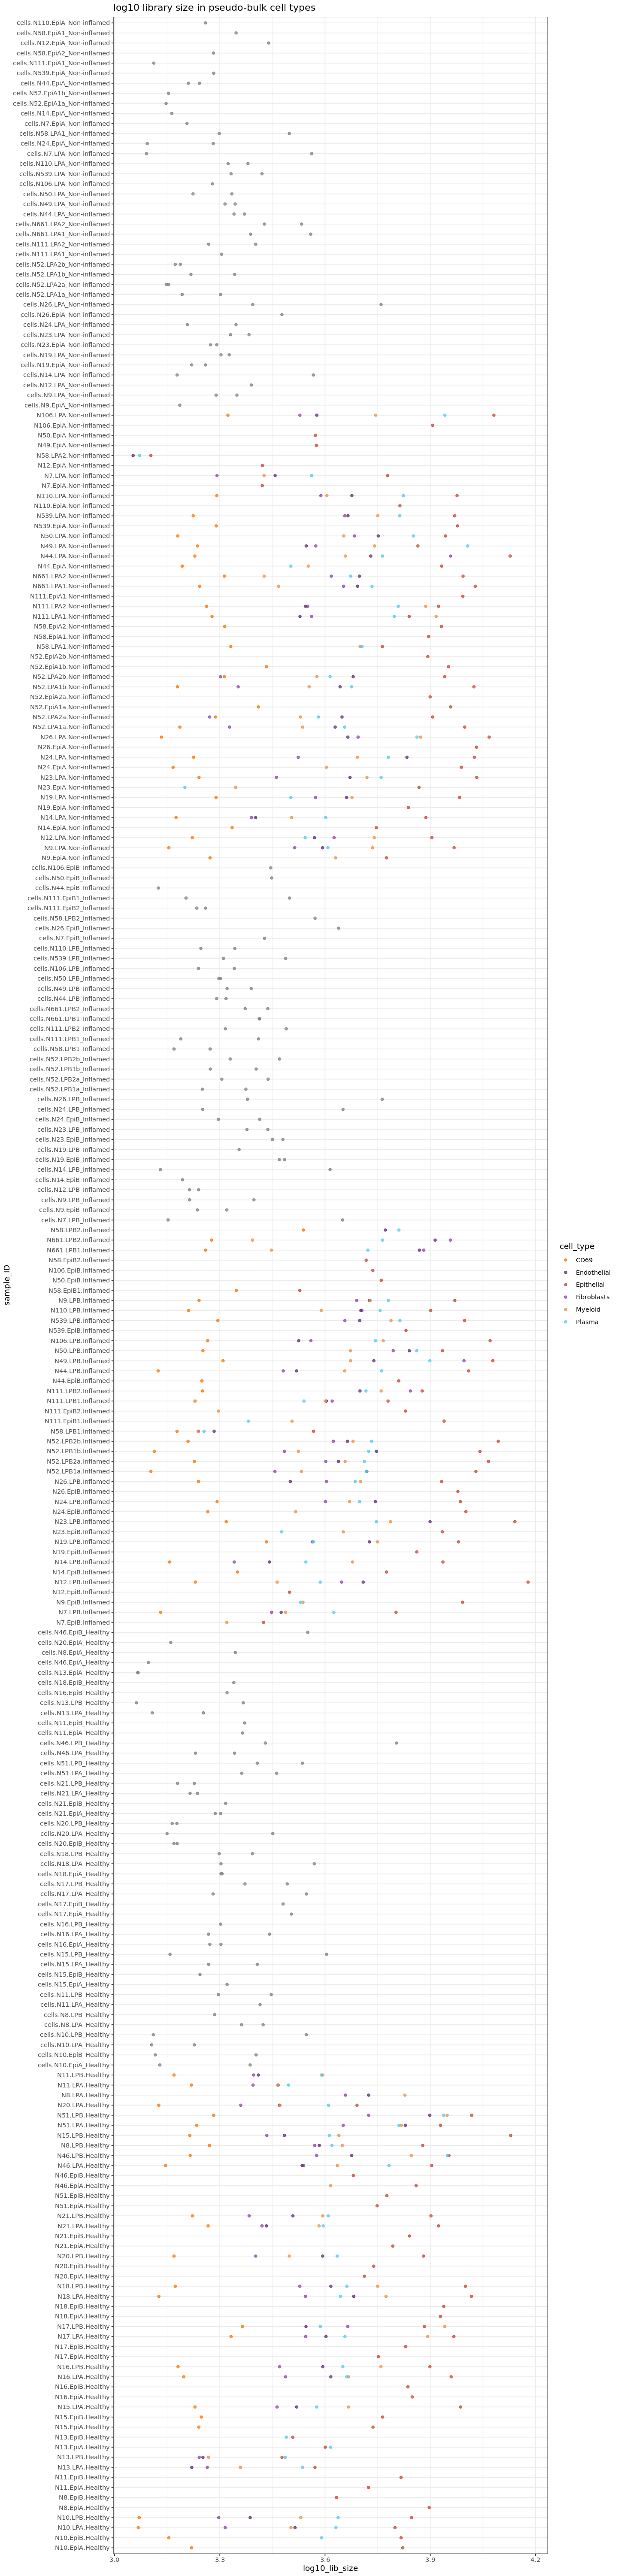

In [286]:
# visualize expression in pseudo sorted bulk
options(repr.plot.width=12, repr.plot.height=50) # plot margins

#my_sampes <- sub("_.*", "", colnames(counts_raw_pseudobulkCellType))
my_sampes <- sub("_.*", "", colnames(counts_raw_pseudobulkCellType))
df <- data.frame(log10_lib_size = log10(colSums(counts_raw_pseudobulkCellType) +1),
                 sample_ID = sub("_", ".", sub("^[^_]+_", "", colnames(counts_raw_pseudobulkCellType))),
                 cell_type = sub("_.*", "", colnames(counts_raw_pseudobulkCellType)))
df$sample_ID <- factor(df$sample_ID, levels = unique(df$sample_ID))

ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
                  ,color = cell_type
             )
) +
        #geom_violin() + 
        geom_jitter(height = NULL
                    ,width = 0
                    ,alpha = 0.75) +
        ggtitle("log10 library size in pseudo-bulk cell types") +
        coord_flip() +
#        ylim(c(0,4.5)) +
        scale_color_manual(values = color_celltype)+
        theme_bw()

### visualize possible filtering parameters

In [287]:
nr_expressing_cell_types <- rowSums(counts_raw_pseudobulkCellType != 0)

anno_genes_cf_ctf$sum_pseudobulkCellType_expr = rowSums(as.matrix(counts_raw_pseudobulkCellType))
anno_genes_cf_ctf$sum_pseudobulkCellType_expr_threshold <- rep(threshold_sum_pseudobulkCellType_expr, nrow(anno_genes_cf_ctf))
anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter <- anno_genes_cf_ctf$sum_pseudobulkCellType_expr > threshold_sum_pseudobulkCellType_expr
print(str(anno_genes_cf_ctf))

'data.frame':	21784 obs. of  7 variables:
 $ gene_symbol                          : chr  "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
 $ inDB                                 : logi  FALSE TRUE FALSE FALSE TRUE FALSE ...
 $ isLigand                             : logi  FALSE FALSE FALSE FALSE TRUE FALSE ...
 $ isReceptor                           : logi  FALSE TRUE FALSE FALSE FALSE FALSE ...
 $ sum_pseudobulkCellType_expr          : num  3.68 1.54 7.86 21.39 614.63 ...
 $ sum_pseudobulkCellType_expr_threshold: num  5 5 5 5 5 5 5 5 5 5 ...
 $ sum_pseudobulkCellType_expr_filter   : logi  FALSE FALSE TRUE TRUE TRUE FALSE ...
NULL


In [288]:
print(paste("we have"
            ,nrow(counts_cf_ctf)
            ,"genes before filtering"
)
)
print(paste("we have"
            ,sum(anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter)
            ,"genes after filtering"
)
)

[1] "we have 21784 genes before filtering"
[1] "we have 13146 genes after filtering"


In [289]:
str(counts_cf_ctf)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:310587570] 15 46 72 77 89 631 715 742 745 755 ...
  ..@ p       : int [1:261945] 0 1119 2653 4695 7361 10651 12424 13627 16104 19225 ...
  ..@ Dim     : int [1:2] 21784 261944
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:21784] "7SK" "A1BG" "A1BG-AS1" "A1CF" ...
  .. ..$ : chr [1:261944] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:310587570] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()


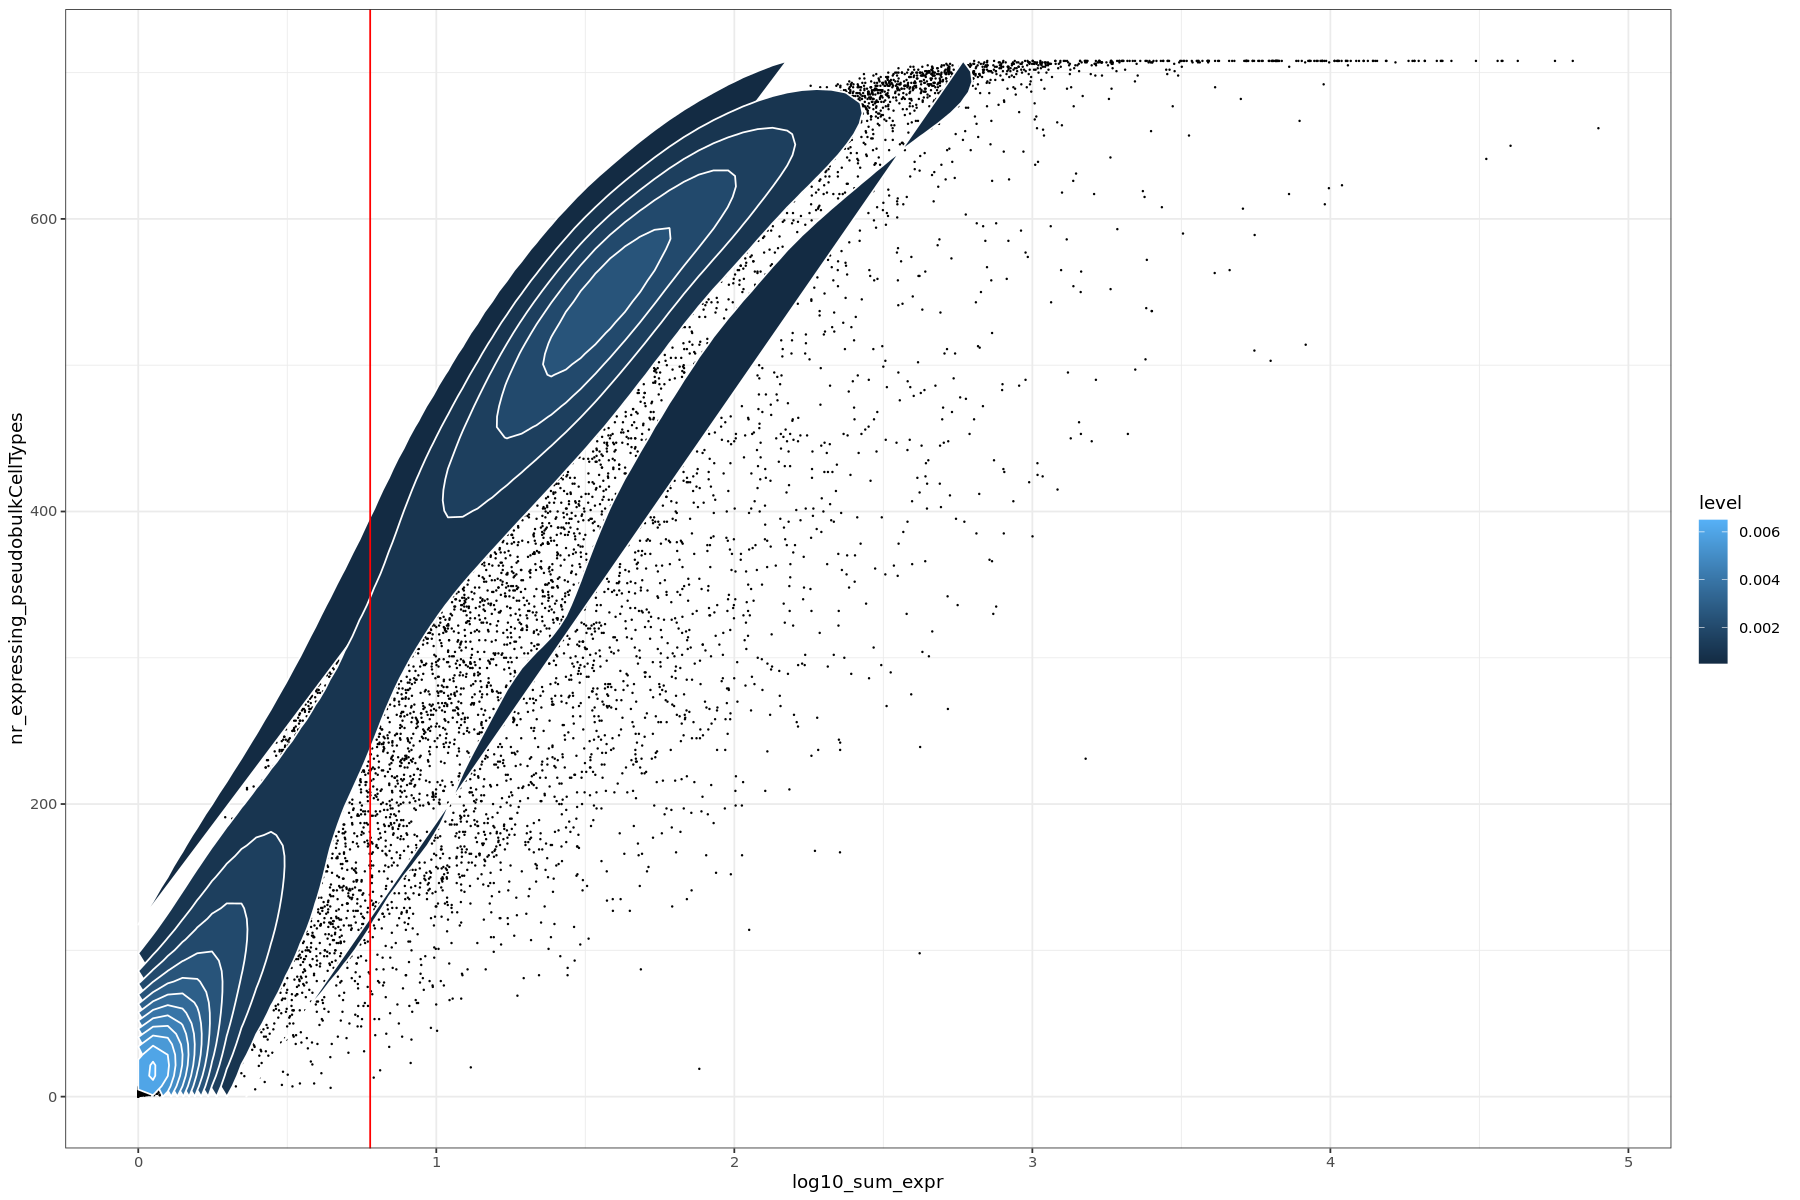

In [290]:
options(repr.plot.width=15,repr.plot.height=10)
# plot sum expression vs nr expressing pseudobulk cell types
df <- data.frame(log10_sum_expr = log10(rowSums(as.matrix(counts_raw_pseudobulkCellType)) +1)
                 ,nr_expressing_pseudobulkCellTypes = nr_expressing_cell_types
                 ,passed_gene_filter = anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter
)

ggplot(data = df
             ,aes(x = log10_sum_expr
                  ,y = nr_expressing_pseudobulkCellTypes
             )
) +
        geom_point(size = 0.05)+
        stat_density_2d(aes(fill = ..level..), geom = "polygon", colour="white") +
        geom_vline(xintercept = log10(threshold_sum_pseudobulkCellType_expr+1), color = "red")+
        theme_bw()

### filter genes

In [291]:
# filter genes by gene filter from the gene annotation file
counts_cf_ctf_gf <- counts_cf_ctf[anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter,]
print(dim(counts_cf_ctf_gf))
str(counts_cf_ctf_gf)

[1]  13146 261944
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:306593256] 9 28 47 51 63 156 179 200 202 211 ...
  ..@ p       : int [1:261945] 0 1109 2616 4632 7263 10497 12253 13436 15881 18927 ...
  ..@ Dim     : int [1:2] 13146 261944
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:13146] "A1BG-AS1" "A1CF" "A2M" "A4GALT" ...
  .. ..$ : chr [1:261944] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:306593256] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()


In [292]:
# filter gene annotation by gene filter from the gene annotation file
anno_genes_cf_ctf_gf <- anno_genes_cf_ctf[anno_genes_cf_ctf$sum_pseudobulkCellType_expr_filter,]

In [293]:
# store total counts per cell after gene filtering in the cell annotation file
anno_cells_cf_ctf_gf <- anno_cells_cf_ctf
anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf <- colSums(counts_cf_ctf_gf)

In [294]:
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf

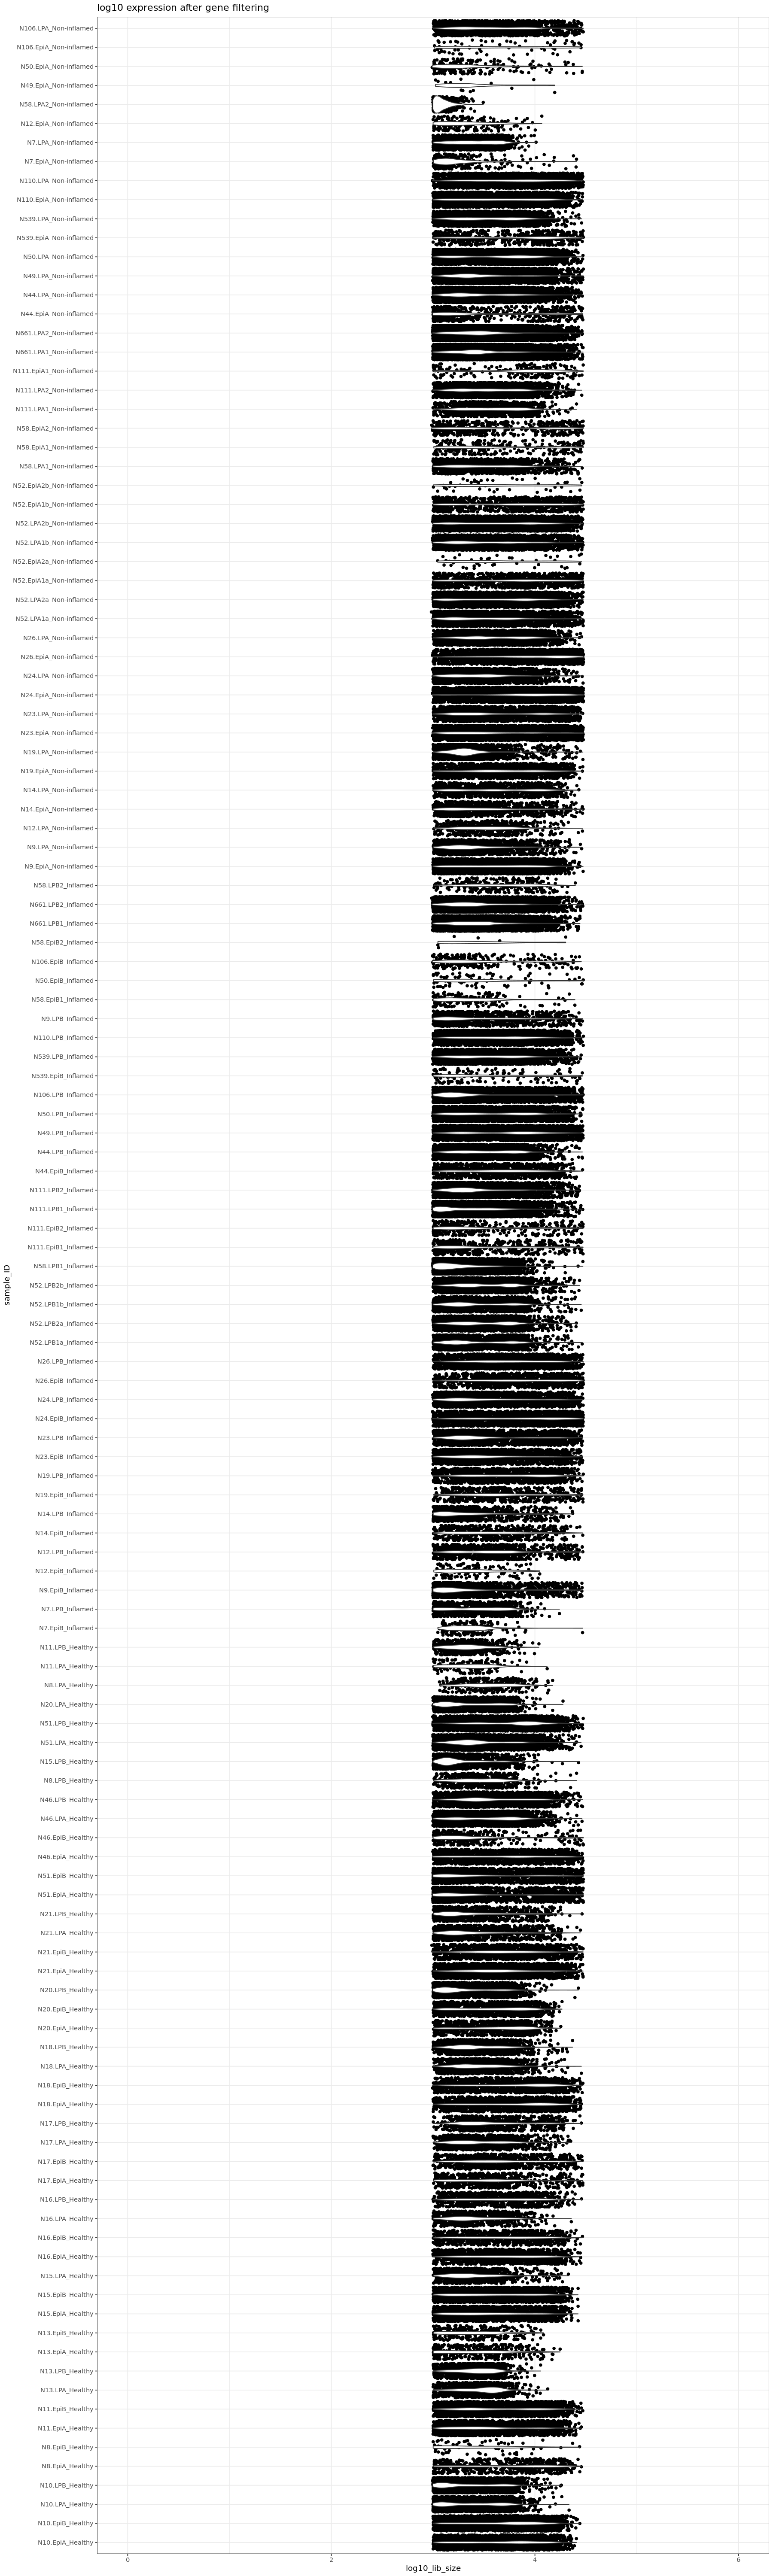

In [295]:
# visualize the expression after gene filter
options(repr.plot.width=15,repr.plot.height=50)
df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf +1)
                 ,sample_ID = anno_cells_cf_ctf_gf$sample_ID
)
df$sample_ID <- factor(df$sample_ID, levels = unique(df$sample_ID))

ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL) +
        geom_violin() + 
        ggtitle("log10 expression after gene filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

### export

In [296]:
# #save counts_cf_ctf_gf.RData
# save(counts_cf_ctf_gf, file = "counts_cf_ctf_gf.RData")

# #save anno_cells_cf_ctf_gf.RData
# save(anno_cells_cf_ctf_gf, file = "anno_cells_cf_ctf_gf.RData")

# #save anno_samples_cf_ctf_gf.RData
# save(anno_samples_cf_ctf_gf, file = "anno_samples_cf_ctf_gf.RData")
# 3
# #save anno_genes_cf_ctf_gf.RData
# save(anno_genes_cf_ctf_gf, file = "anno_genes_cf_ctf_gf.RData")

## Filter samples

Samples with less than 5 cell types will be filtered out.

- **INPUT:**
    - ```counts_cf_ctf_gf.RData``` 
    - ```anno_cells_cf_ctf_gf.RData```
    - ```anno_samples_cf_ctf_gf.RData```
    - ```anno_genes_cf_ctf_gf.RData```
    
- **NOTES:**

    The '_sf' ending in the file names stands for sample filter.
    
- **OUTPUT:**

    -  ```counts_cf_ctf_gf_sf.RData``` 
    -  ```anno_cells_cf_ctf_gf_sf.RData``` 
    -  ```anno_samples_cf_ctf_gf_sf.RData```
    -  ```anno_genes_cf_ctf_gf_sf.RData```

In [297]:
# print("load counts")
# load("./AML_healthy/counts_cf_ctf_gf.RData")
# print("dim(counts_cf_ctf_gf)")
# print(dim(counts_cf_ctf_gf))

# # load cell annotation
# print("load cell annotation")
# load("./AML_healthy/anno_cells_cf_ctf_gf.RData")
# print("str(anno_cells_cf_ctf_gf)")
# print(str(anno_cells_cf_ctf_gf))

# # load sample annotation
# print("load sample annotation")
# load("./AML_healthy/anno_samples_cf_ctf_gf.RData")
# print("str(anno_samples_cf_ctf_gf)")
# print(str(anno_samples_cf_ctf_gf))

# # load gene annotation
# print("load gene annotation")
# load("./AML_healthy/anno_genes_cf_ctf_gf.RData")
# print("str(anno_genes_cf_ctf_gf)")
# print(str(anno_genes_cf_ctf_gf))

In [298]:
# thresholds ####
threshold_nr_celltypes <- 7
print(paste("A sample should contain at least"
            ,threshold_nr_celltypes
            ,"cell types"))

[1] "A sample should contain at least 7 cell types"


### filter

In [300]:
# filter out samples that are not present in the cell annotation
print(dim(anno_samples_cf_ctf_gf))
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf_gf[anno_samples_cf_ctf_gf$sample_ID %in% unique(anno_cells_cf_ctf_gf$sample_ID),]
print(dim(anno_samples_cf_ctf_gf))

[1] 133   7
[1] 133   7


In [301]:
rownames(anno_samples_cf_ctf_gf) <- anno_samples_cf_ctf_gf$sample_ID
anno_samples_cf_ctf_gf <- anno_samples_cf_ctf_gf[unique(anno_cells_cf_ctf_gf$sample_ID),]
print(dim(anno_samples_cf_ctf_gf))

[1] 133   7


In [302]:
# store total counts per sample after gene filtering in the sample annotation file
anno_samples_cf_ctf_gf$total_counts_raw_cf_ctf_gf <- sapply(unique(anno_cells_cf_ctf_gf$sample_ID)
                                                         ,function(sample){
                                                             #print(sample)
                                                                 idx_sample <- anno_cells_cf_ctf_gf$sample_ID == sample
                                                             #print(sum(idx_sample))
                                                                 sum(anno_cells_cf_ctf_gf$total_counts_raw_cf_ctf_gf[idx_sample])
                                                         })

In [303]:
# store number of cell types per sample after gene filtering in the sample annotation file
anno_samples_cf_ctf_gf$nr_celltypes_cf_ctf_gf <- sapply(anno_samples_cf_ctf_gf$sample_ID
                                                         ,function(sample){
                                                                 idx_sample <- anno_cells_cf_ctf_gf$sample_ID == sample
                                                                 length(unique(anno_cells_cf_ctf_gf$cell_type[idx_sample]))
                                                         })

In [304]:
anno_samples_cf_ctf_gf$threshold_nr_celltypes <- paste("greater or equal"
                                              ,threshold_nr_celltypes)
anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes <- anno_samples_cf_ctf_gf$nr_celltypes_cf_ctf_gf >= threshold_nr_celltypes


In [305]:
print(paste("we have"
            ,sum(anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes)
            ,"samples that passed the threshold"))
print(paste("we have"
            ,sum(!anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes)
            ,"samples that didn't pass the threshold:"))

[1] "we have 67 samples that passed the threshold"
[1] "we have 66 samples that didn't pass the threshold:"


In [306]:
bad_samples <- anno_samples_cf_ctf_gf$sample_ID[!anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes]
print(bad_samples)

 [1] "N10.EpiA_Healthy"        "N10.EpiB_Healthy"       
 [3] "N8.EpiA_Healthy"         "N8.EpiB_Healthy"        
 [5] "N11.EpiA_Healthy"        "N11.EpiB_Healthy"       
 [7] "N13.EpiA_Healthy"        "N13.EpiB_Healthy"       
 [9] "N15.EpiA_Healthy"        "N15.EpiB_Healthy"       
[11] "N16.EpiA_Healthy"        "N16.EpiB_Healthy"       
[13] "N17.EpiA_Healthy"        "N17.EpiB_Healthy"       
[15] "N18.EpiA_Healthy"        "N18.EpiB_Healthy"       
[17] "N20.EpiA_Healthy"        "N20.EpiB_Healthy"       
[19] "N21.EpiA_Healthy"        "N21.EpiB_Healthy"       
[21] "N51.EpiA_Healthy"        "N51.EpiB_Healthy"       
[23] "N46.EpiA_Healthy"        "N46.EpiB_Healthy"       
[25] "N8.LPA_Healthy"          "N11.LPA_Healthy"        
[27] "N7.EpiB_Inflamed"        "N9.EpiB_Inflamed"       
[29] "N12.EpiB_Inflamed"       "N14.EpiB_Inflamed"      
[31] "N19.EpiB_Inflamed"       "N23.EpiB_Inflamed"      
[33] "N24.EpiB_Inflamed"       "N26.EpiB_Inflamed"      
[35] "N111.EpiB1_Inflamed"     

### visualization

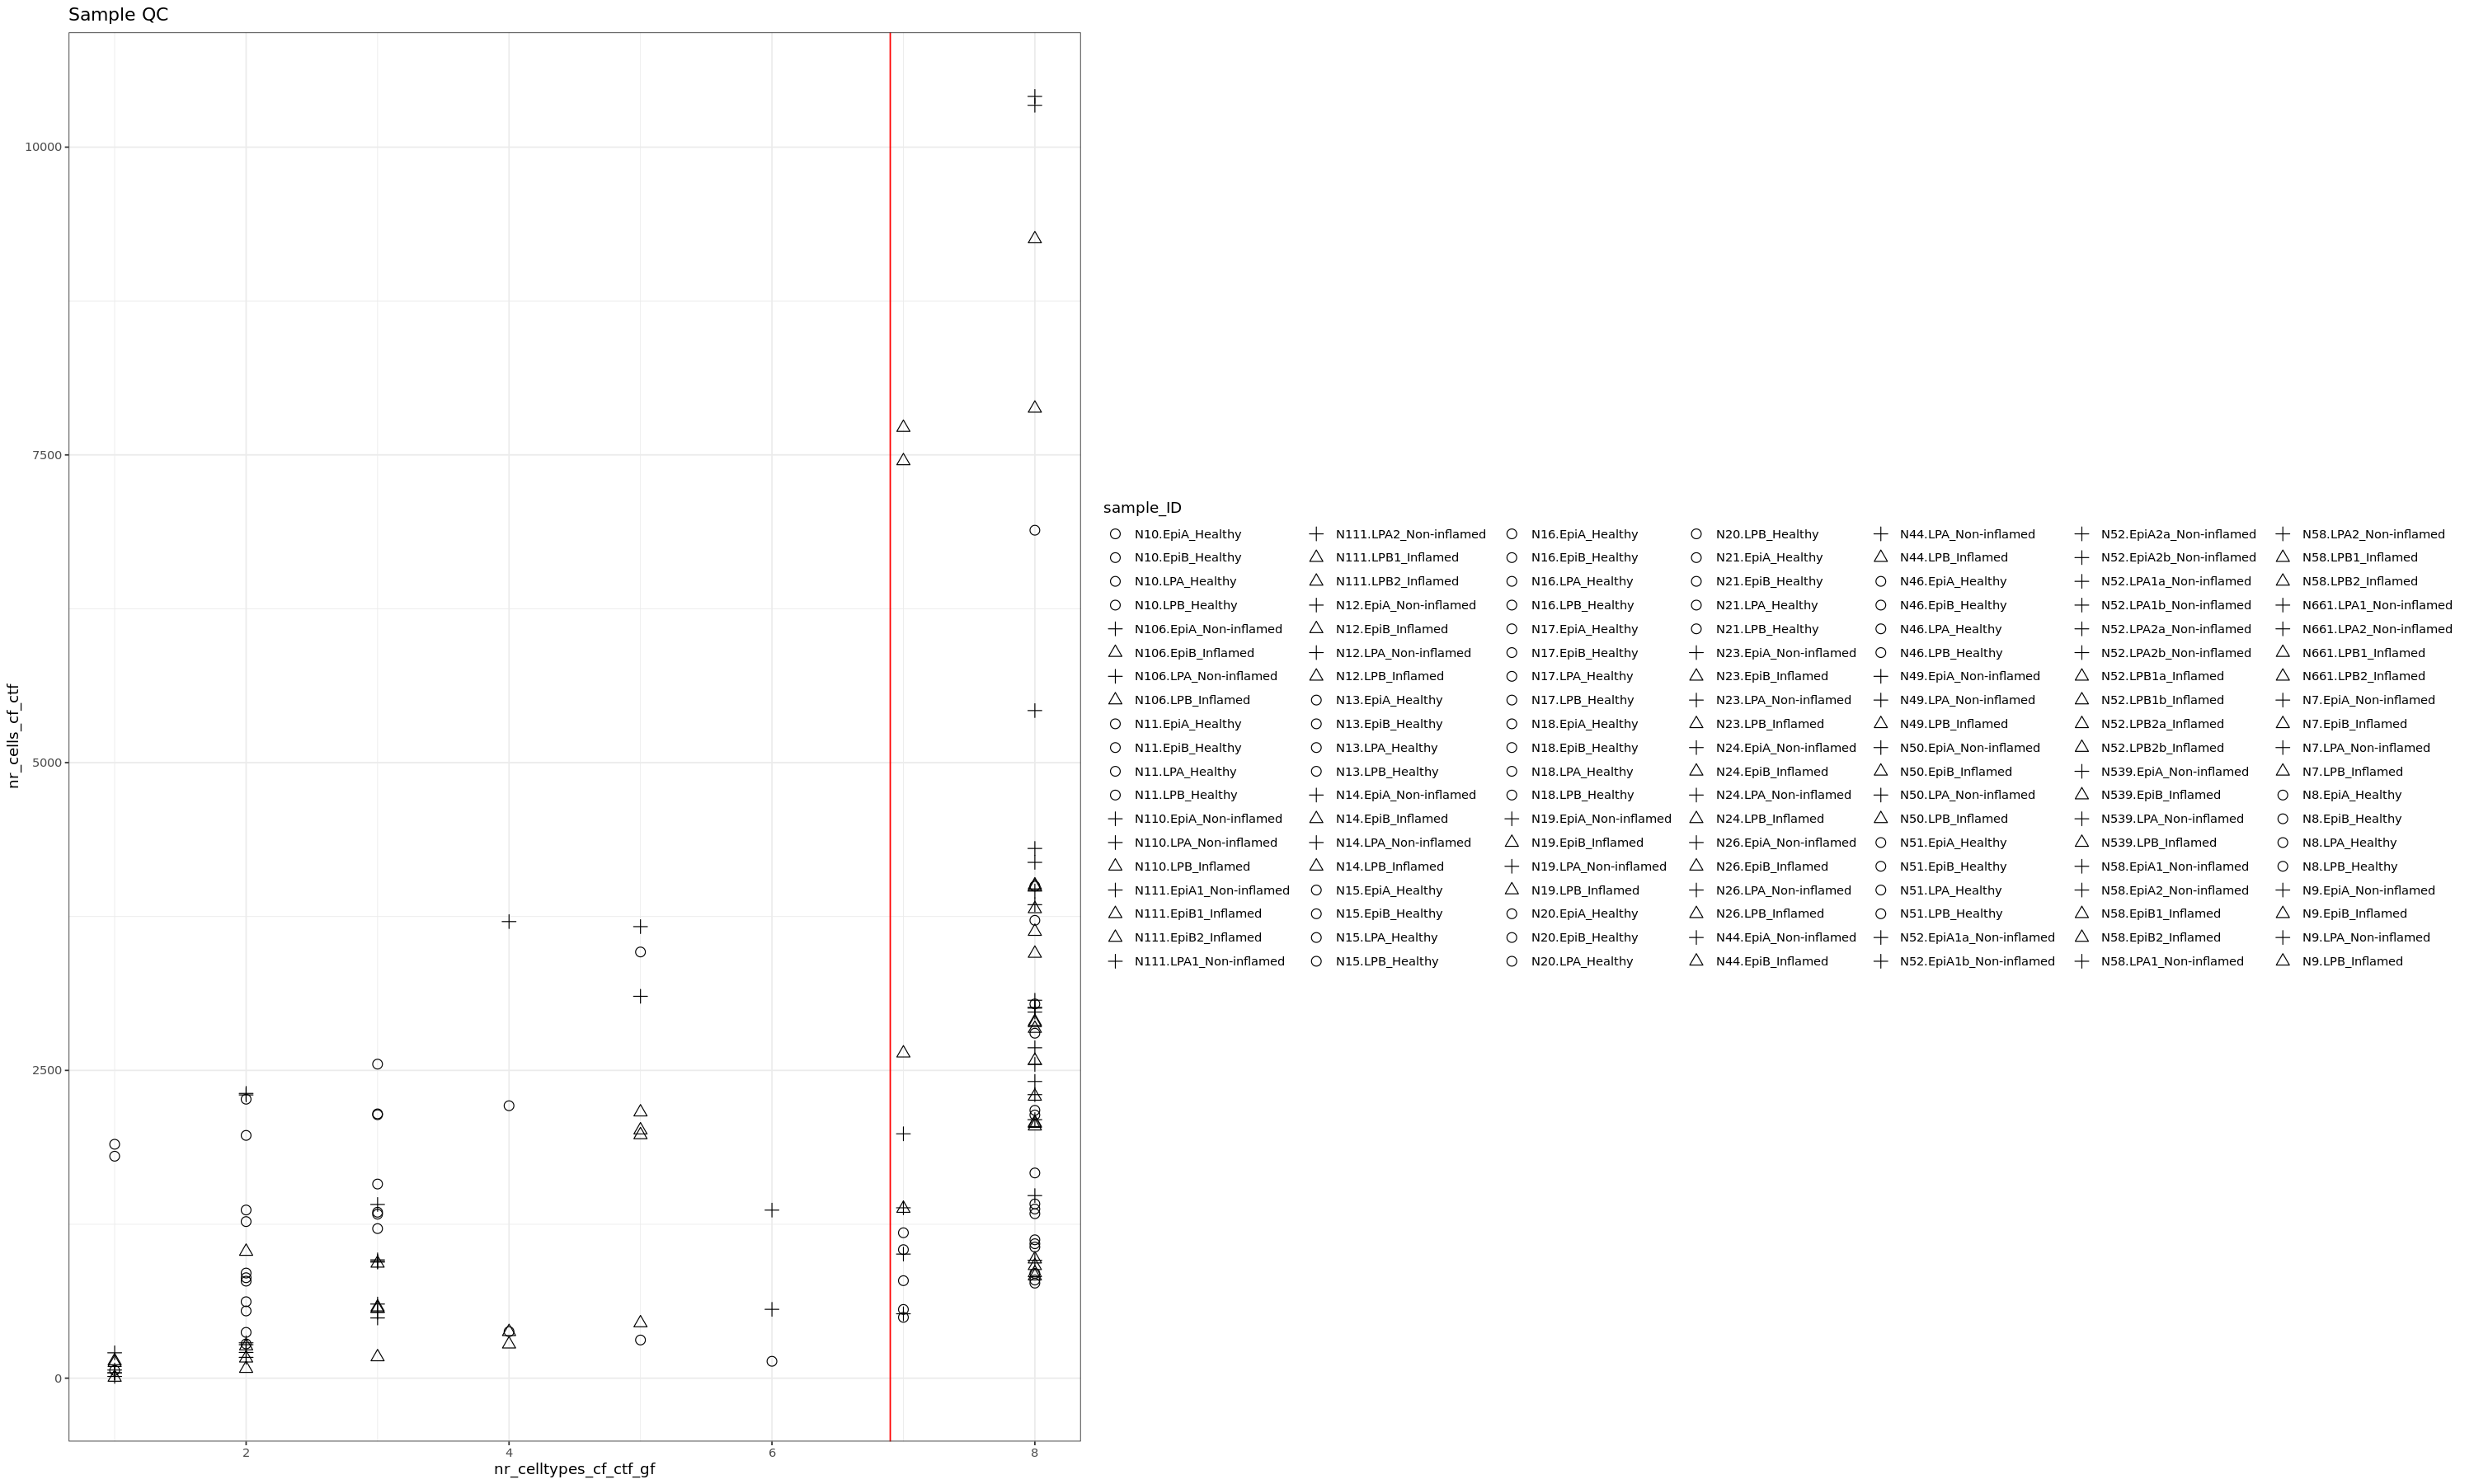

In [307]:
options(repr.plot.width=25,repr.plot.height=15)
ggplot(data = anno_samples_cf_ctf_gf
       ,aes(x = nr_celltypes_cf_ctf_gf
            ,y = nr_cells_cf_ctf
            #,color = sample_ID
            ,shape = sample_ID
            ,size = sample_ID
       )
) +
        geom_point()+
        ggtitle("Sample QC") +
        geom_vline(xintercept = threshold_nr_celltypes- 0.1
                   ,color = "red")+
        scale_shape_manual(values=shape_sample)+
        scale_size_manual(values=size_sample)+
        theme_bw()

In [308]:
#subset anno_anno_samples_cf_ctf_gf

print("dim(anno_samples_cf_ctf_gf) before filtering")
print(dim(anno_samples_cf_ctf_gf))
anno_samples_cf_ctf_gf_sf <- anno_samples_cf_ctf_gf[anno_samples_cf_ctf_gf$passed_threshold_nr_celltypes,]
print("dim(anno_samples_cf_ctf_gf_sf) after filtering")
print(dim(anno_samples_cf_ctf_gf_sf))

[1] "dim(anno_samples_cf_ctf_gf) before filtering"
[1] 133  11
[1] "dim(anno_samples_cf_ctf_gf_sf) after filtering"
[1] 67 11


In [309]:
#subset anno_cells

print("dim(anno_cells_cf_ctf_gf) before filtering")
print(dim(anno_cells_cf_ctf_gf))
idx_bad <- anno_cells_cf_ctf_gf$sample_ID %in% bad_samples
anno_cells_cf_ctf_gf_sf <- anno_cells_cf_ctf_gf[!idx_bad,]
print("dim(anno_cells_cf_ctf_gf_sf) after filtering")
print(dim(anno_cells_cf_ctf_gf_sf))

[1] "dim(anno_cells_cf_ctf_gf) before filtering"
[1] 261944     21
[1] "dim(anno_cells_cf_ctf_gf_sf) after filtering"
[1] 192698     21


In [310]:
#subset counts_cf_ctf_gf

print("dim(counts_cf_ctf_gf) before filtering")
print(dim(counts_cf_ctf_gf))
str(counts_cf_ctf_gf)
counts_cf_ctf_gf_sf <- counts_cf_ctf_gf[,!idx_bad]
print("dim(counts_cf_ctf_gf_sf) after filtering")
print(dim(counts_cf_ctf_gf_sf))

[1] "dim(counts_cf_ctf_gf) before filtering"
[1]  13146 261944
Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:306593256] 9 28 47 51 63 156 179 200 202 211 ...
  ..@ p       : int [1:261945] 0 1109 2616 4632 7263 10497 12253 13436 15881 18927 ...
  ..@ Dim     : int [1:2] 13146 261944
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:13146] "A1BG-AS1" "A1CF" "A2M" "A4GALT" ...
  .. ..$ : chr [1:261944] "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
  ..@ x       : num [1:306593256] 2 1 1 1 1 1 3 2 2 1 ...
  ..@ factors : list()
[1] "dim(counts_cf_ctf_gf_sf) after filtering"
[1]  13146 192698


In [311]:
anno_cells_cf_ctf_gf_sf$total_counts_raw_cf_ctf_gf_sf <- colSums(counts_cf_ctf_gf_sf)

anno_genes_cf_ctf_gf_sf <- anno_genes_cf_ctf_gf

## Extra Filtering Steps

In [316]:
strings <- unique(anno_cells_cf_ctf_gf_sf$sample_ID)

In [333]:
# extract patient_id, sample, and health status using regular expressions
patient_id <- sub("\\..*", "", strings)
sample <- sub(".*\\.", "", strings)
sample <- sub("_.*$", "", sample)


health_status <- sub(".*_", "", strings)

In [334]:
sample

[1] "LPA"   "LPB"   "LPA"   "LPB"   "LPA"   "LPA"   "LPB"   "LPA"   "LPB"  
[10] "LPA"   "LPB"   "LPB"   "LPA"   "LPB"   "LPA"   "LPB"   "LPB"   "LPB"  
[19] "LPA"   "LPB"   "LPA"   "LPB"   "LPB"   "LPB"   "LPB"   "LPB"   "LPB"  
[28] "LPB"   "LPB"   "LPB1a" "LPB2a" "LPB1b" "LPB2b" "LPB1"  "LPB1"  "LPB2" 
[37] "LPB"   "LPB"   "LPB"   "LPB"   "LPB"   "LPB"   "LPB"   "LPB1"  "LPB2" 
[46] "LPA"   "LPA"   "LPA"   "LPA"   "LPA"   "LPA"   "LPA"   "LPA1a" "LPA2a"
[55] "LPA1b" "LPA2b" "LPA1"  "LPA2"  "LPA1"  "LPA2"  "LPA"   "LPA"   "LPA"  
[64] "LPA"   "LPA"   "LPA"   "LPA"

In [335]:
df <- data.frame(patient_id, sample, health_status)

In [343]:
for (x in unique(df$patient_id)){
    
    filter(df, patient_id==x)
}

In [340]:
filter(df, patient_id=='N10')

patient_id sample health_status
1 N10        LPA    Healthy      
2 N10        LPB    Healthy

In [313]:
print(unique(anno_cells_cf_ctf_gf_sf$sample_ID), column=TRUE)



 [1] "N10.LPA_Healthy"        "N10.LPB_Healthy"        "N13.LPA_Healthy"       
 [4] "N13.LPB_Healthy"        "N15.LPA_Healthy"        "N16.LPA_Healthy"       
 [7] "N16.LPB_Healthy"        "N17.LPA_Healthy"        "N17.LPB_Healthy"       
[10] "N18.LPA_Healthy"        "N18.LPB_Healthy"        "N20.LPB_Healthy"       
[13] "N21.LPA_Healthy"        "N21.LPB_Healthy"        "N46.LPA_Healthy"       
[16] "N46.LPB_Healthy"        "N8.LPB_Healthy"         "N15.LPB_Healthy"       
[19] "N51.LPA_Healthy"        "N51.LPB_Healthy"        "N20.LPA_Healthy"       
[22] "N11.LPB_Healthy"        "N7.LPB_Inflamed"        "N12.LPB_Inflamed"      
[25] "N14.LPB_Inflamed"       "N19.LPB_Inflamed"       "N23.LPB_Inflamed"      
[28] "N24.LPB_Inflamed"       "N26.LPB_Inflamed"       "N52.LPB1a_Inflamed"    
[31] "N52.LPB2a_Inflamed"     "N52.LPB1b_Inflamed"     "N52.LPB2b_Inflamed"    
[34] "N58.LPB1_Inflamed"      "N111.LPB1_Inflamed"     "N111.LPB2_Inflamed"    
[37] "N44.LPB_Inflamed"       "N49.LPB_I

In [200]:
anno_cells_cf_ctf_gf_sf <- anno_cells_cf_ctf_gf_sf[!grepl("LPB_Healthy|LPB2|LPA1b|LPA2a|LPA2b|LPB1b|LPB2a|LPB2b|N661|N7|N12|N19|N23|N58|N539|N106|LPA_Inflamed", anno_cells_cf_ctf_gf_sf$sample_ID),]

In [201]:
unique(anno_cells_cf_ctf_gf_sf$sample_ID)

[1] "N10.LPA_Healthy"        "N15.LPA_Healthy"        "N16.LPA_Healthy"       
 [4] "N17.LPA_Healthy"        "N18.LPA_Healthy"        "N21.LPA_Healthy"       
 [7] "N46.LPA_Healthy"        "N51.LPA_Healthy"        "N20.LPA_Healthy"       
[10] "N14.LPB_Inflamed"       "N24.LPB_Inflamed"       "N26.LPB_Inflamed"      
[13] "N52.LPB1a_Inflamed"     "N111.LPB1_Inflamed"     "N44.LPB_Inflamed"      
[16] "N49.LPB_Inflamed"       "N50.LPB_Inflamed"       "N110.LPB_Inflamed"     
[19] "N9.LPB_Inflamed"        "N9.LPA_Non-inflamed"    "N14.LPA_Non-inflamed"  
[22] "N24.LPA_Non-inflamed"   "N26.LPA_Non-inflamed"   "N52.LPA1a_Non-inflamed"
[25] "N111.LPA2_Non-inflamed" "N44.LPA_Non-inflamed"   "N49.LPA_Non-inflamed"  
[28] "N50.LPA_Non-inflamed"   "N110.LPA_Non-inflamed"

In [202]:
anno_cells_cf_ctf_gf_sf

sample_ID            cell_type_original tissue_type
N10.LPA.TTGCTATGACGCAT   N10.LPA_Healthy      Stem               Epithelial 
N15.LPA.ATGCGCCTCAACTG   N15.LPA_Healthy      Stem               Epithelial 
N15.LPA.GCACAAACAACGAA   N15.LPA_Healthy      Stem               Epithelial 
N15.LPA.GCTACCTGCCTAAG   N15.LPA_Healthy      Stem               Epithelial 
N15.LPA.GTATTCACCATGGT   N15.LPA_Healthy      Stem               Epithelial 
N15.LPA.TTGAACCTGTGAGG   N15.LPA_Healthy      Stem               Epithelial 
N16.LPA.AGTTTGCTCCCTAC   N16.LPA_Healthy      Stem               Epithelial 
N16.LPA.CACAACGACGTTGA   N16.LPA_Healthy      Stem               Epithelial 
N17.LPA.AGCATTCTGGGCAA   N17.LPA_Healthy      Stem               Epithelial 
N17.LPA.AGCCTCTGAGAGGC   N17.LPA_Healthy      Stem               Epithelial 
N17.LPA.GCAACTGACGTTAG   N17.LPA_Healthy      Stem               Epithelial 
N17.LPA.GCTGATGATTCGTT   N17.LPA_Healthy      Stem               Epithelial 
N18.LPA.CTATTGACGTGTCA   N18.LPA_Healthy      Stem               Epithelial 
N18.LPA.GCAGGGCTGTAAAG   N18.LPA_Healthy      Stem               Epithelial 
N18.LPA.TCAGCAGAGCTACA   N18.LPA_Healthy      Stem               Epithelial 
N21.LPA.AAGAAGACTCATTC   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.ACCCTCGATGTAGC   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.ACTTTGTGTATTCC   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.ATCTTGACCCTACC   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.CACCCATGTTCTAC   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.CAGATGACGTGAGG   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.CGGGACTGGAAAGT   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.GAACCAACGGAACG   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.GCTATACTCCTTTA   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.GGATTTCTGCGAAG   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.GGGACCTGTGAGGG   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.GTATGGTGTCTCCG   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.GTCCACACTCAAGC   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.TAATCCACTTTGCT   N21.LPA_Healthy      Stem               Epithelial 
N21.LPA.TAGTCTTGAAACAG   N21.LPA_Healthy      Stem               Epithelial 
⋮                        ⋮                    ⋮                  ⋮          
N44.LPA.CTCGTACTCCTTGCCA N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.CTCTAATGTGTCCTCT N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GACCAATTCCCAGGTG N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GACTACATCGCCCTTA N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GCACATACAGTCGATT N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GCCAAATCAAATACAG N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GCGGGTTCAAAGTGCG N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GCTCCTACACGGTTTA N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GGACAAGAGTGACTCT N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GGATGTTAGGCCATAG N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GGGAATGCAACGATGG N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GGGATGACAACTTGAC N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GGGTCTGTCATGGTCA N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GTACGTATCTGTGCAA N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GTGCAGCAGCTAACAA N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GTGCATAAGCTACCGC N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.GTTTCTAGTCGCATAT N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.TGGACGCGTTACGACT N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.TGGCTGGGTTCACGGC N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.TGTTCCGTCTTAGCCC N44.LPA_Non-inflamed Cycling B          Immune     
N44.LPA.TTCTACATCTGTC

In [205]:
counts_cf_ctf_gf_sf <- counts_cf_ctf_gf_sf[,colnames(counts_cf_ctf_gf_sf) %in% anno_cells_cf_ctf_gf_sf$cell_ID ]

In [206]:
str(counts_cf_ctf_gf_sf)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:91274251] 6 10 31 47 51 58 63 100 147 150 ...
  ..@ p       : int [1:81834] 0 1540 3907 5821 7923 9500 12052 14289 15511 18334 ...
  ..@ Dim     : int [1:2] 13146 81833
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:13146] "A1BG-AS1" "A1CF" "A2M" "A4GALT" ...
  .. ..$ : chr [1:81833] "N10.LPA.TTGCTATGACGCAT" "N15.LPA.ATGCGCCTCAACTG" "N15.LPA.GCACAAACAACGAA" "N15.LPA.GCTACCTGCCTAAG" ...
  ..@ x       : num [1:91274251] 1 2 1 2 1 2 1 1 1 1 ...
  ..@ factors : list()


In [207]:
# visualize expression after sample filter

df <- data.frame(log10_lib_size = log10(anno_cells_cf_ctf_gf_sf$total_counts_raw_cf_ctf_gf_sf +1)
                 ,sample_ID = anno_cells_cf_ctf_gf_sf$sample_ID
)
df$sample_ID <- factor(df$sample_ID, levels = unique(df$sample_ID))
print(str(df))

'data.frame':	81833 obs. of  2 variables:
 $ log10_lib_size: num  3.92 4.07 3.92 4.02 3.82 ...
 $ sample_ID     : Factor w/ 29 levels "N10.LPA_Healthy",..: 1 2 2 2 2 2 3 3 4 4 ...
NULL


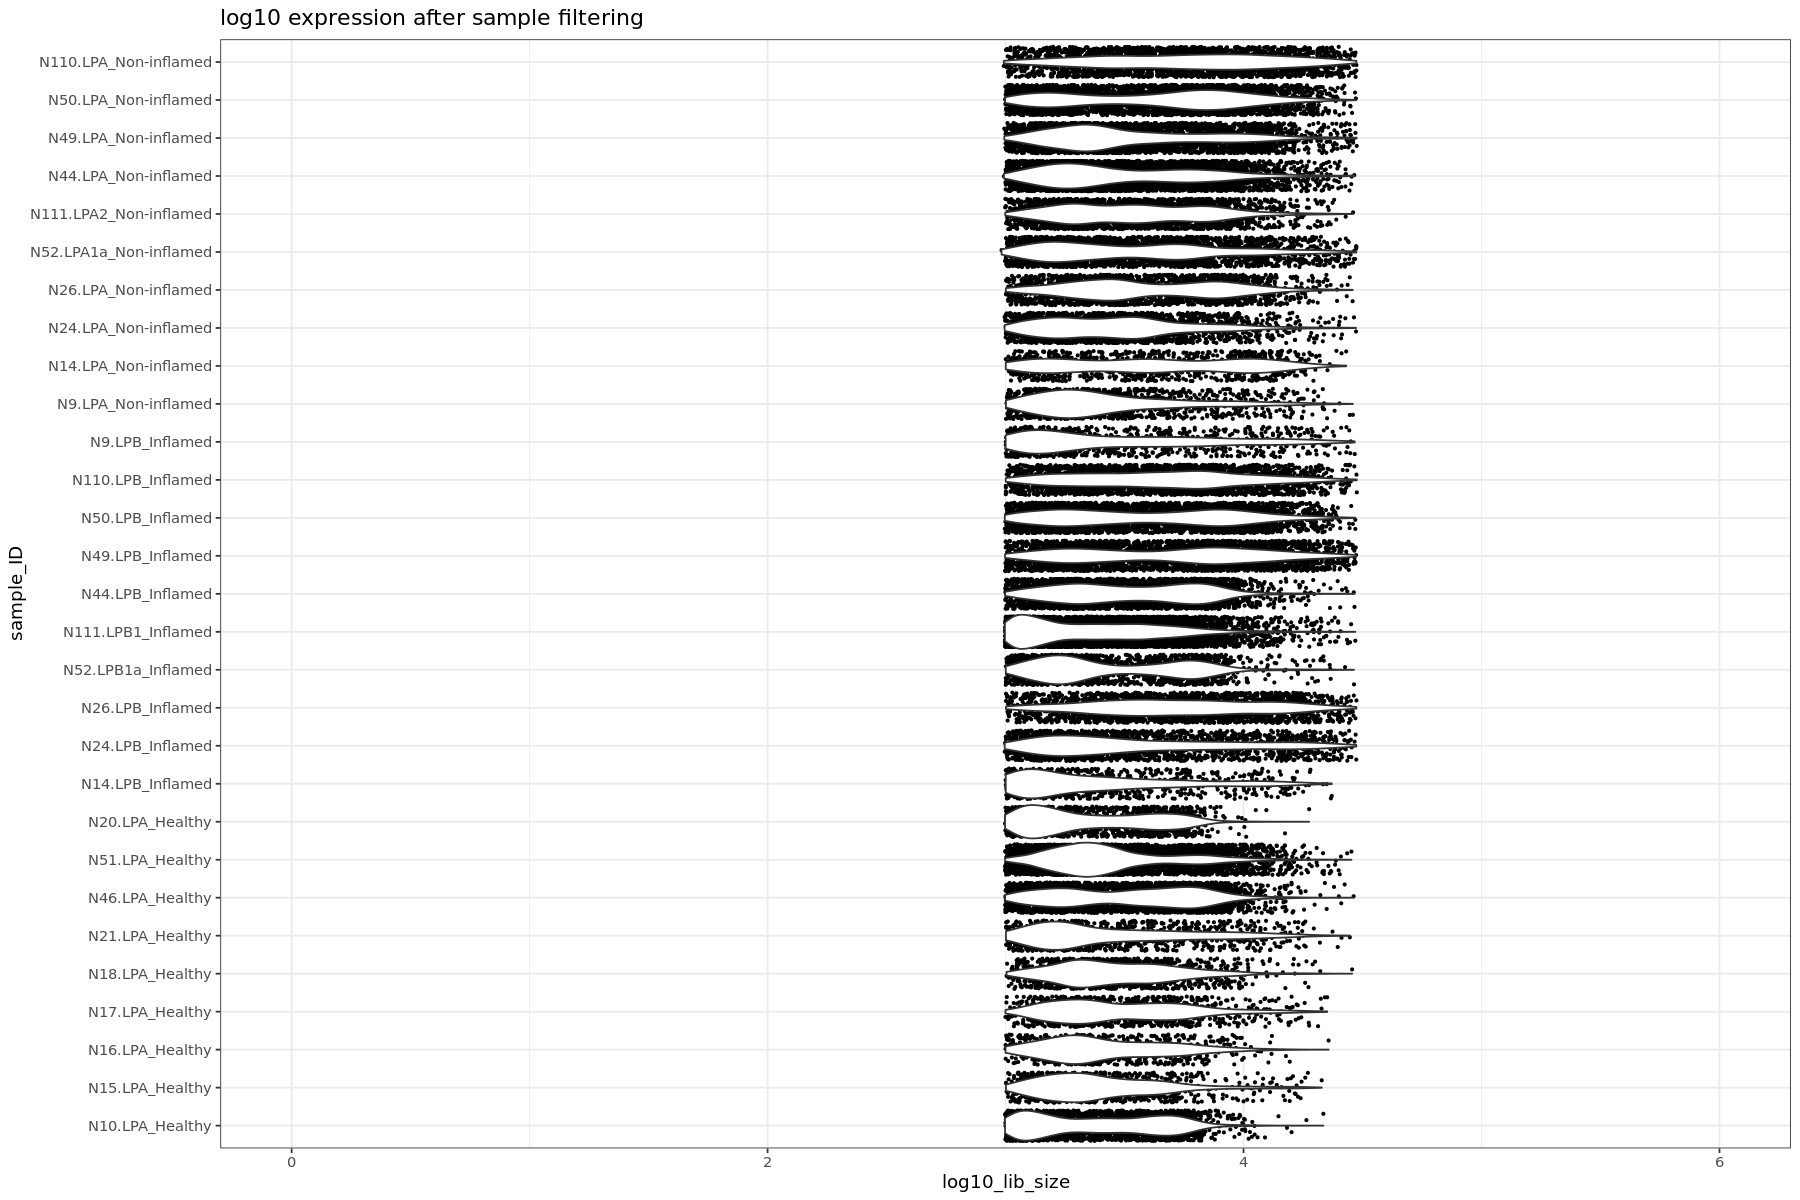

In [208]:
options(repr.plot.width=15,repr.plot.height=10)
ggplot(data = df
             ,aes(x = sample_ID
                  ,y = log10_lib_size
             )
) +
        geom_jitter(height = NULL
                    ,size = 0.5) +
        geom_violin() + 
        ggtitle("log10 expression after sample filtering") +
        coord_flip() +
        ylim(c(0,6))+
        theme_bw()

rm(df)

### heatmap

In [211]:
unique(anno_cells_cf_ctf_gf_sf$sample_ID)

[1] "N10.LPA_Healthy"        "N15.LPA_Healthy"        "N16.LPA_Healthy"       
 [4] "N17.LPA_Healthy"        "N18.LPA_Healthy"        "N21.LPA_Healthy"       
 [7] "N46.LPA_Healthy"        "N51.LPA_Healthy"        "N20.LPA_Healthy"       
[10] "N14.LPB_Inflamed"       "N24.LPB_Inflamed"       "N26.LPB_Inflamed"      
[13] "N52.LPB1a_Inflamed"     "N111.LPB1_Inflamed"     "N44.LPB_Inflamed"      
[16] "N49.LPB_Inflamed"       "N50.LPB_Inflamed"       "N110.LPB_Inflamed"     
[19] "N9.LPB_Inflamed"        "N9.LPA_Non-inflamed"    "N14.LPA_Non-inflamed"  
[22] "N24.LPA_Non-inflamed"   "N26.LPA_Non-inflamed"   "N52.LPA1a_Non-inflamed"
[25] "N111.LPA2_Non-inflamed" "N44.LPA_Non-inflamed"   "N49.LPA_Non-inflamed"  
[28] "N50.LPA_Non-inflamed"   "N110.LPA_Non-inflamed"

In [212]:
unique(anno_cells_cf_ctf_gf_sf$cell_type)

[1] "Epithelial"  "Fibroblasts" "Endothelial" "Myeloid"     "CD69"       
[6] "T_cells"     "Plasma"      "B_cells"

In [213]:
options(repr.plot.width=15,repr.plot.height=15)

anno_cells_cf_ctf_gf_sf <- anno_cells_cf_ctf_gf_sf %>% 
  arrange(region)

df <- table(data.frame(sample_ID = anno_cells_cf_ctf_gf_sf$sample_ID
                       ,cell_type = anno_cells_cf_ctf_gf_sf$cell_type)
            )

df <- t(matrix(df
               ,ncol = ncol(df)
               ,dimnames=dimnames(df)
               )
        )

 'table' int [1:29, 1:8] 86 6 33 133 3115 5 5 17 20 15 ...
 - attr(*, "dimnames")=List of 2
  ..$ sample_ID: chr [1:29] "N10.LPA_Healthy" "N110.LPA_Non-inflamed" "N110.LPB_Inflamed" "N111.LPA2_Non-inflamed" ...
  ..$ cell_type: chr [1:8] "B_cells" "CD69" "Endothelial" "Epithelial" ...
 int [1:8, 1:29] 86 10 69 59 593 160 1122 703 6 55 ...
 - attr(*, "dimnames")=List of 2
  ..$ cell_type: chr [1:8] "B_cells" "CD69" "Endothelial" "Epithelial" ...
  ..$ sample_ID: chr [1:29] "N10.LPA_Healthy" "N110.LPA_Non-inflamed" "N110.LPB_Inflamed" "N111.LPA2_Non-inflamed" ...


In [299]:
df <- as.data.frame(df)
df1 <- data.frame(matrix(ncol = length(unique(anno_cells_cf_ctf_gf_sf$sample_ID)), nrow = length(unique(anno_cells_cf_ctf_gf_sf$cell_type))))
colnames(df1) <- unique(anno_cells_cf_ctf_gf_sf$sample_ID)
rownames(df1) <- rownames(df)

ERROR: Error in as.data.frame.default(df): kann Klasse ‘"function"’ nicht in data.frame umwandeln


In [219]:
for (x in colnames(df1)){
    df1[[x]] <- df[[x]]
}

In [220]:
library("circlize")
library("ComplexHeatmap")

In [221]:
col_fun = colorRamp2(c(0
                       ,10
                       ,100
                       ,1000
                       , max(df1)), c("white"
                                     ,"lightgoldenrod1"
                                     ,"gold"
                                     ,"salmon"
                                     , "darkred"))

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


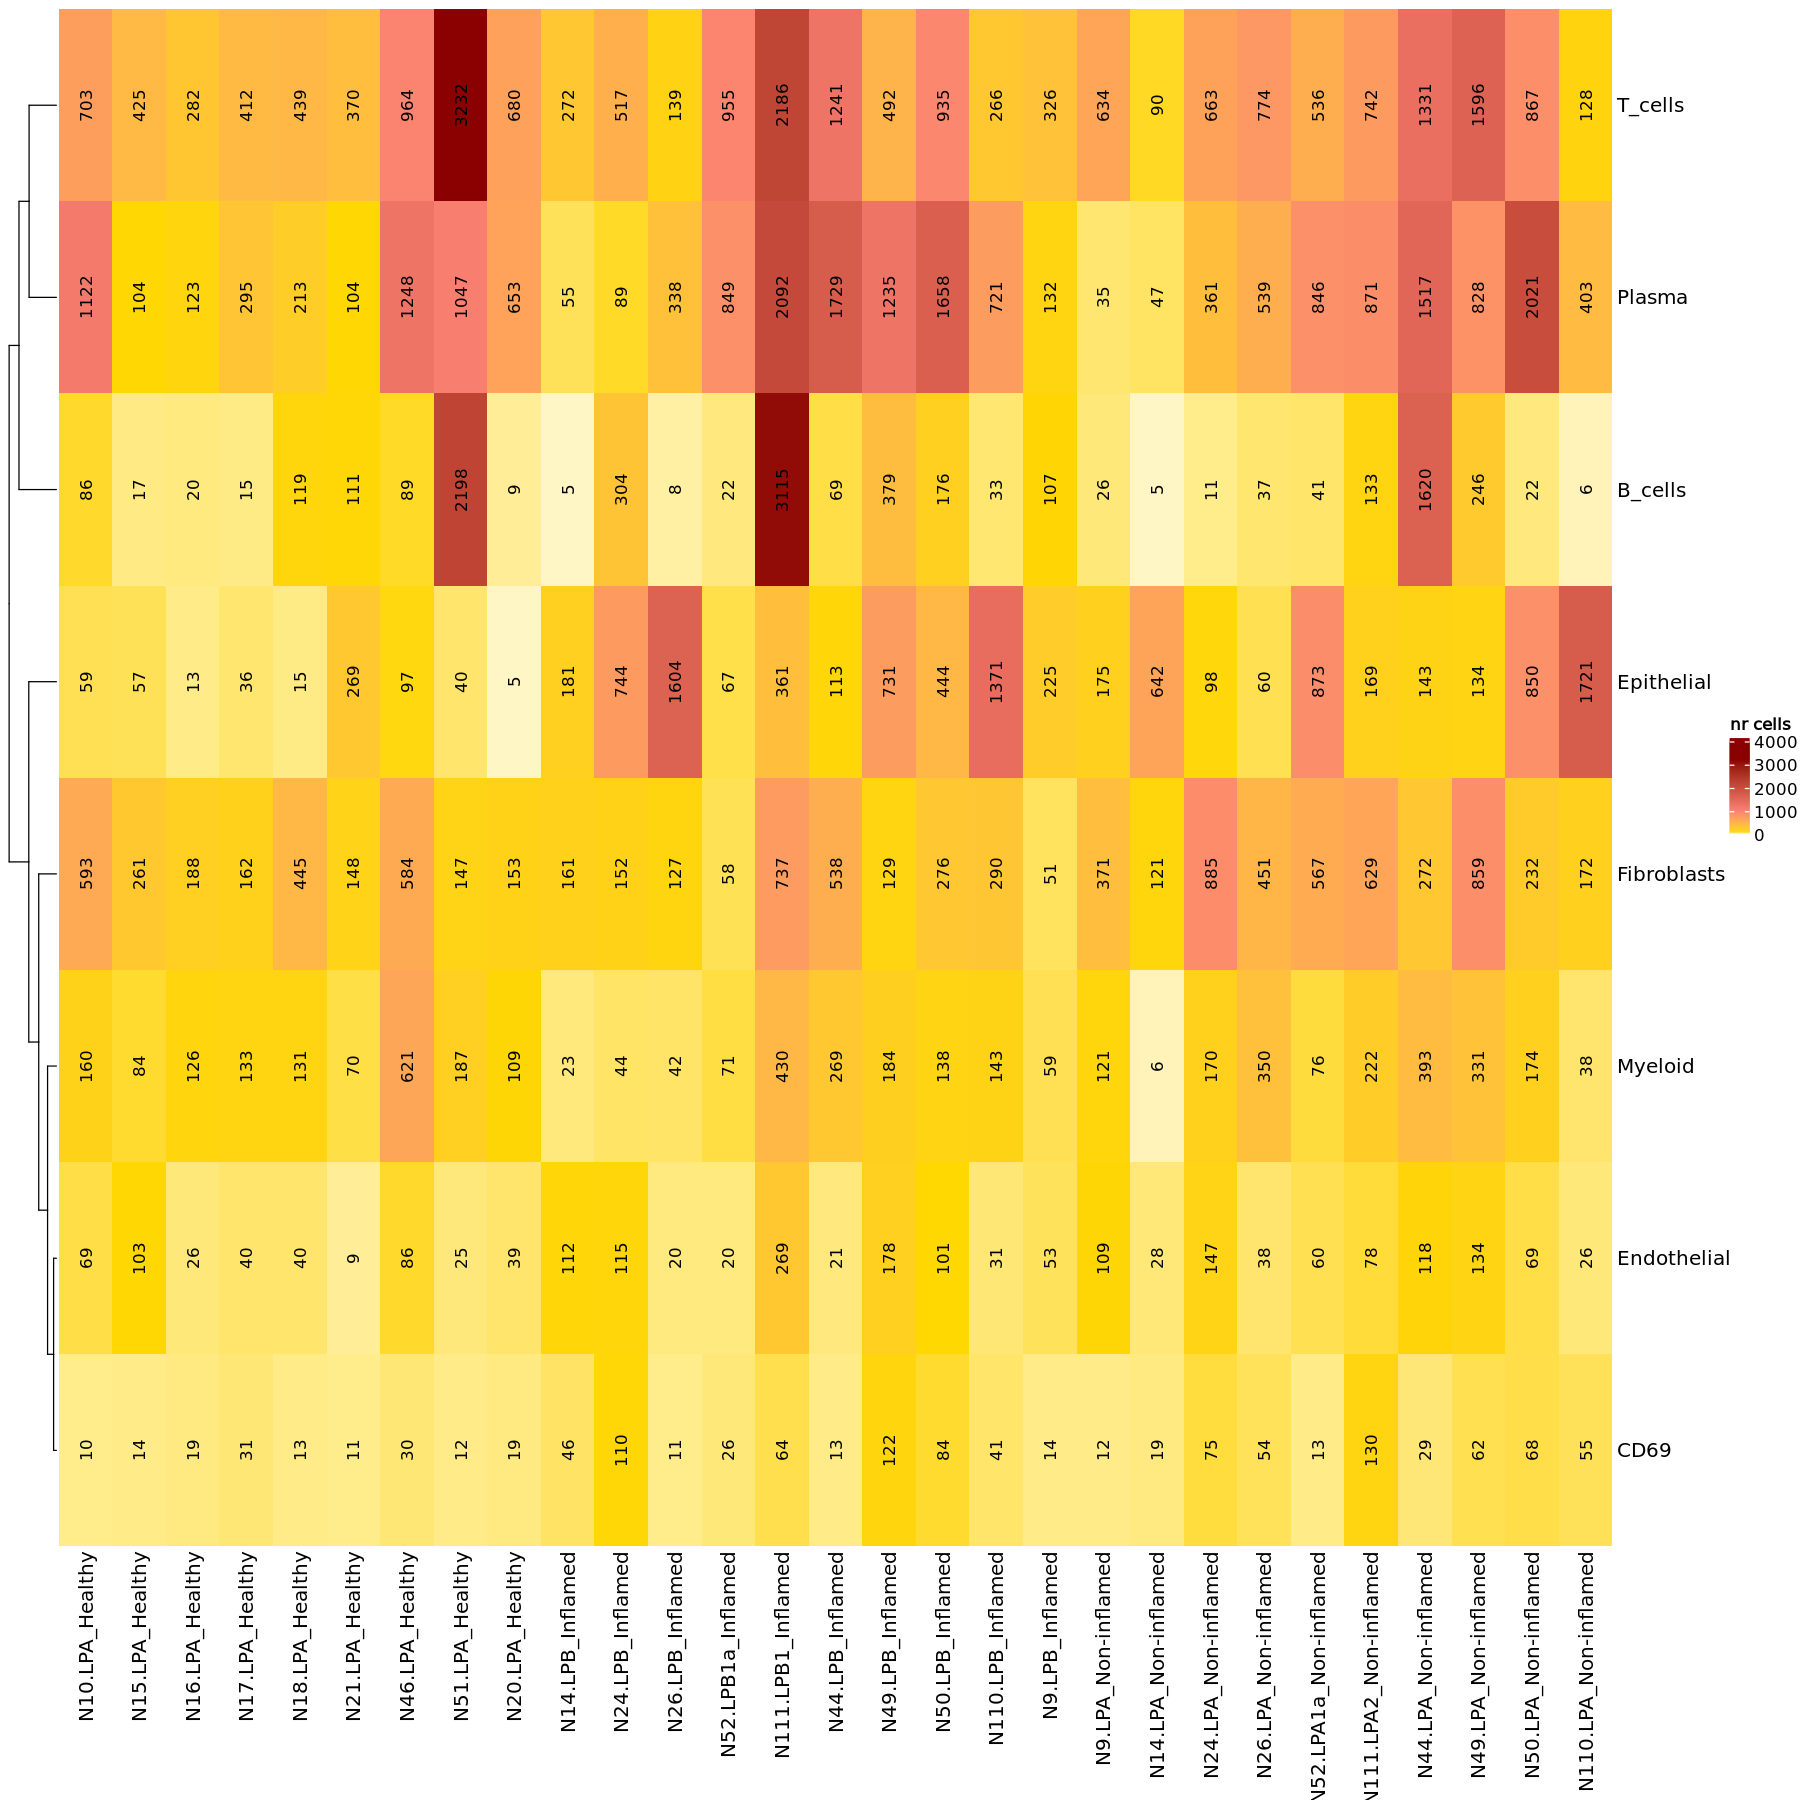

In [222]:
Heatmap(df1
        ,cluster_columns = F
        ,col = col_fun
        ,name="nr cells"
        ,show_heatmap_legend = TRUE
        ,cell_fun = function(j, i, x, y, width, height, fill) {
                grid.text(as.character(df1[i, j])#sprintf("%.1f", df[i, j])
                          , x
                          , y
                          , gp = gpar(fontsize = 10
                                      )
                          ,rot=90
                          )
                }
        )

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


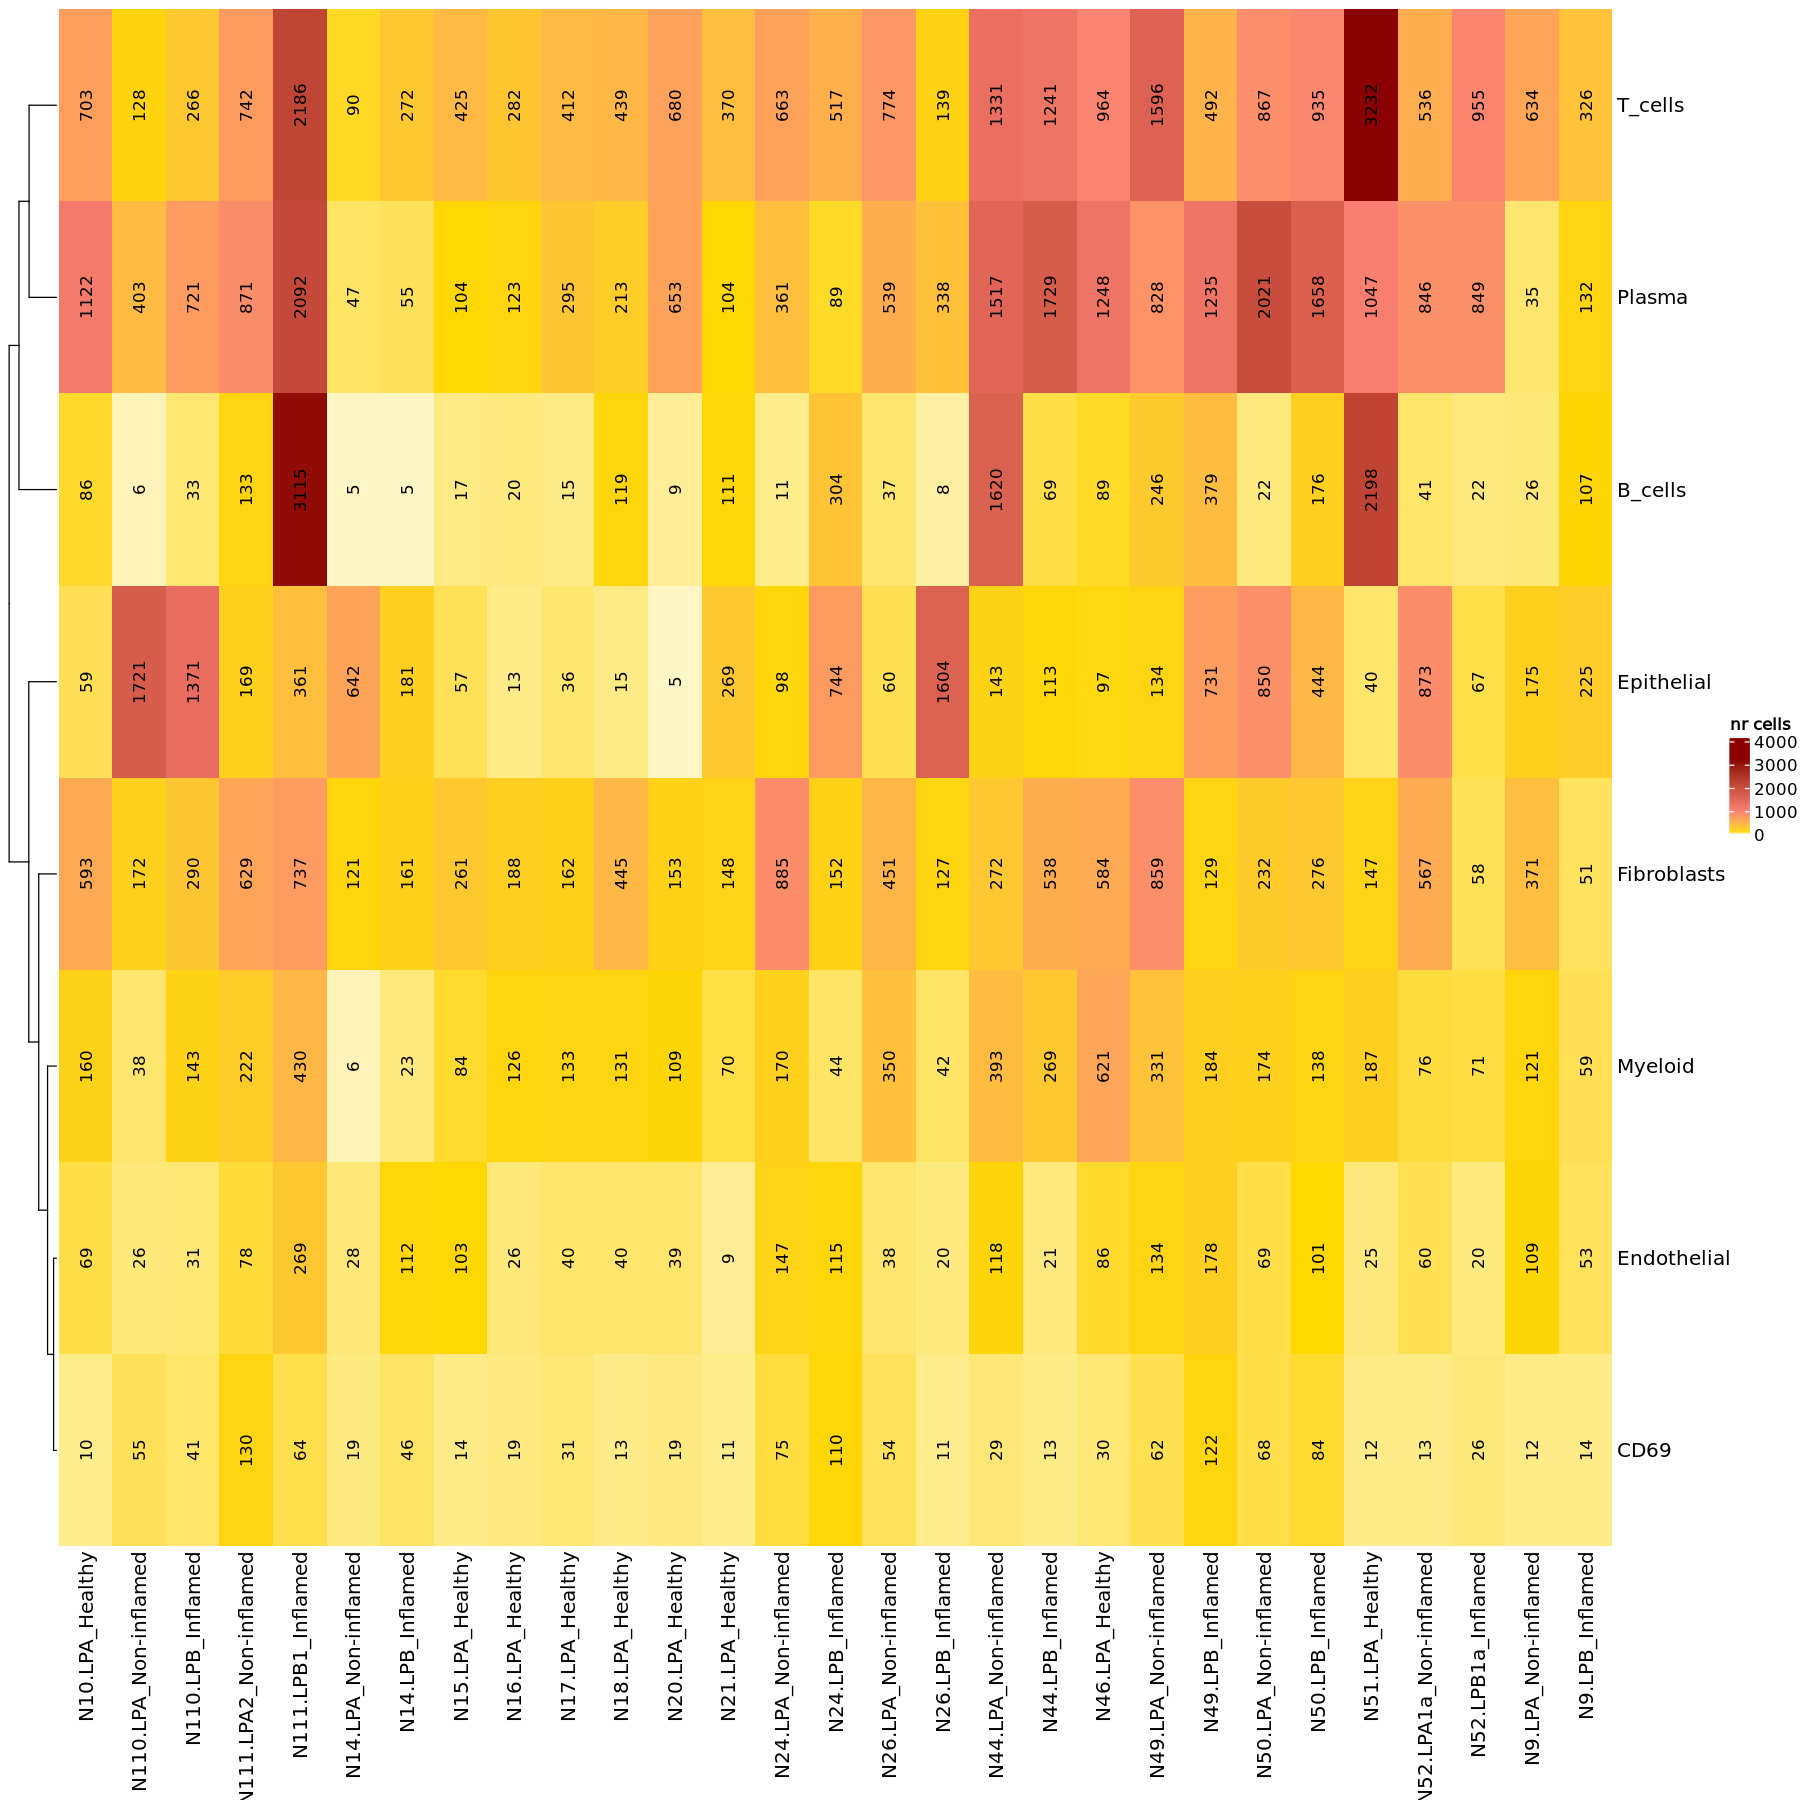

In [223]:
Heatmap(df
        ,cluster_columns = F
        ,col = col_fun
        ,name="nr cells"
        ,show_heatmap_legend = TRUE
        ,cell_fun = function(j, i, x, y, width, height, fill) {
                grid.text(as.character(df[i, j])#sprintf("%.1f", df[i, j])
                          , x
                          , y
                          , gp = gpar(fontsize = 10
                                      )
                          ,rot=90
                          )
                }
        )

### export

In [224]:
# save counts
library(Matrix)
writeMM(obj = Matrix(as.matrix(counts_cf_ctf_gf_sf), sparse=TRUE), file = "./pdata/counts_norm.mtx")

# export anno_cells
write.table(anno_cells_cf_ctf_gf_sf,file = "./pdata/anno_cells_norm.txt",sep = "\t",row.names = FALSE )

# export anno_genes
write.table(anno_genes_cf_ctf_gf_sf,file = "./pdata/anno_genes_norm.txt",sep = "\t",row.names = FALSE)

# export anno_samples
write.table(anno_samples_cf_ctf_gf_sf,file = "./pdata/anno_samples_norm.txt",sep = "\t",row.names = FALSE)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 8.0 GiB”


NULL